In [1]:
%matplotlib inline
import os
import sys
import math
import datetime
import numpy as np
from numpy.random import random
import pandas as pd
import pyworld
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from IPython.display import Audio
from tensorflow.keras import *
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.activations import sigmoid, relu, tanh

C:\Users\Suisei_Saika\Anaconda3\envs\tf2g\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
tf.random.set_seed(115)

In [3]:
class DataLoader():
    def __init__(self, dataset_a, dataset_b, sampling_rate = 22050, num_mcep = 32, frame_period = 5.0, n_frames = 128):
        self.sampling_rate = sampling_rate
        self.num_mcep = num_mcep
        self.frame_period = frame_period
        self.n_frames = n_frames
        self.dataset_a = dataset_a
        self.dataset_b = dataset_b
    def load_batch(self, batch_size=1):
        path_A = glob('./*.wav')
        path_B = glob('./*.wav')
        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)
        dataset_A = []
        dataset_B = []
        for i in range(self.n_batches):
        # for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            for wav_A, wav_B in zip(batch_A, batch_B):
                wavs_A = self.load_wavs(wav_dir = wav_A, sr = self.sampling_rate)
                wavs_B = self.load_wavs(wav_dir = wav_B, sr = self.sampling_rate)
                f0s_A, timeaxes_A, sps_A, aps_A, coded_sps_A = self.world_encode_data(wavs = wavs_A, fs = self.sampling_rate, frame_period = self.frame_period, coded_dim = self.num_mcep)
                f0s_B, timeaxes_B, sps_B, aps_B, coded_sps_B = self.world_encode_data(wavs = wavs_B, fs = self.sampling_rate, frame_period = self.frame_period, coded_dim = self.num_mcep)

                log_f0s_mean_A, log_f0s_std_A = self.logf0_statistics(f0s_A)
                log_f0s_mean_B, log_f0s_std_B = self.logf0_statistics(f0s_B)
                coded_sps_A_transposed = self.transpose_in_list(lst = coded_sps_A)
                coded_sps_B_transposed = self.transpose_in_list(lst = coded_sps_B)      

                coded_sps_A_norm, coded_sps_A_mean, coded_sps_A_std = self.coded_sps_normalization_fit_transoform(coded_sps = coded_sps_A_transposed)
                coded_sps_B_norm, coded_sps_B_mean, coded_sps_B_std = self.coded_sps_normalization_fit_transoform(coded_sps = coded_sps_B_transposed)  
                
                data_A, data_B = self.sample_train_data(dataset_A = coded_sps_A_norm, dataset_B = coded_sps_B_norm, n_frames = self.n_frames)
                dataset_A = tf.expand_dims(data_A, -1)      
                dataset_B = tf.expand_dims(data_B, -1)
                
            yield dataset_A, dataset_B
            
    def test(self, wav_path_A, wav_path_B, net_AB, net_BA):
        wavs_A = self.load_wavs(wav_dir = wav_path_A, sr = self.sampling_rate)
        wavs_B = self.load_wavs(wav_dir = wav_path_B, sr = self.sampling_rate)
        f0s_A, timeaxes_A, sps_A, aps_A, coded_sps_A = self.world_encode_data(wavs = wavs_A, fs = self.sampling_rate, frame_period = self.frame_period, coded_dim = self.num_mcep)
        f0s_B, timeaxes_B, sps_B, aps_B, coded_sps_B = self.world_encode_data(wavs = wavs_B, fs = self.sampling_rate, frame_period = self.frame_period, coded_dim = self.num_mcep)
        log_f0s_mean_A, log_f0s_std_A = self.logf0_statistics(f0s_A)
        log_f0s_mean_B, log_f0s_std_B = self.logf0_statistics(f0s_B)
        coded_sps_A_transposed = self.transpose_in_list(lst = coded_sps_A)
        coded_sps_B_transposed = self.transpose_in_list(lst = coded_sps_B)      
        
        coded_sps_A_norm, coded_sps_A_mean, coded_sps_A_std = self.coded_sps_normalization_fit_transoform(coded_sps = coded_sps_A_transposed)
        coded_sps_B_norm, coded_sps_B_mean, coded_sps_B_std = self.coded_sps_normalization_fit_transoform(coded_sps = coded_sps_B_transposed) 
                
        wav_transformed_A = self.transfer(wav_path_A, net_AB, coded_sps_A_mean, coded_sps_A_std, coded_sps_B_mean, coded_sps_B_std, log_f0s_mean_A, log_f0s_std_A, log_f0s_mean_B, log_f0s_std_B)
        wav_transformed_B = self.transfer(wav_path_B, net_BA, coded_sps_B_mean, coded_sps_B_std, coded_sps_A_mean, coded_sps_A_std, log_f0s_mean_B, log_f0s_std_B, log_f0s_mean_A, log_f0s_std_A)
        
        return (wav_transformed_A, wav_transformed_B)

    def transfer(self, filepath, net, coded_sps_A_mean, coded_sps_A_std, coded_sps_B_mean, coded_sps_B_std, log_f0s_mean_A, log_f0s_std_A, log_f0s_mean_B, log_f0s_std_B):
        sampling_rate = self.sampling_rate
        frame_period = self.frame_period
        num_mcep = self.num_mcep
        n_frames = self.n_frames
        wav, _ = librosa.load(filepath, sr = sampling_rate, mono = True)
        wav = self.wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
        f0, timeaxis, sp, ap = self.world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period)
        f0_converted = self.pitch_conversion(f0 = f0, mean_log_src = log_f0s_mean_A, std_log_src = log_f0s_std_A, mean_log_target = log_f0s_mean_B, std_log_target = log_f0s_std_B)
        coded_sp = self.world_encode_spectral_envelop(sp = sp, fs = sampling_rate, dim = num_mcep)
        coded_sp_transposed = coded_sp.T
        coded_sp_norm = (coded_sp_transposed - coded_sps_A_mean) / coded_sps_A_std
        coded_sp_norm = self.sample_test_data(coded_sp_norm, n_frames = n_frames)     
        coded_sp_norm = tf.expand_dims(coded_sp_norm, -1)    
        coded_sp_converted_norm = net.predict(coded_sp_norm)
        coded_sp_converted_norm = self.join_test_data(coded_sp_converted_norm, f0, n_frames) 
        coded_sp_converted = coded_sp_converted_norm * coded_sps_B_std + coded_sps_B_mean
        coded_sp_converted = coded_sp_converted.T
        coded_sp_converted = np.ascontiguousarray(coded_sp_converted)
        decoded_sp_converted = self.world_decode_spectral_envelop(coded_sp = coded_sp_converted, fs = sampling_rate)
        wav_transformed = self.world_speech_synthesis(f0 = f0_converted, decoded_sp = decoded_sp_converted, ap = ap, fs = sampling_rate, frame_period = frame_period)
        return wav_transformed
    
    def load_wavs(self, wav_dir, sr):

        wavs = list()
        wav, _ = librosa.load(wav_dir, sr = sr, mono = True)
        #wav = wav.astype(np.float64)
        wavs.append(wav)

        return wavs

    def world_decompose(self, wav, fs, frame_period = 5.0):

        # Decompose speech signal into f0, spectral envelope and aperiodicity using WORLD
        wav = wav.astype(np.float64)
        f0, timeaxis = pyworld.harvest(wav, fs, frame_period = frame_period, f0_floor = 71.0, f0_ceil = 800.0)
        sp = pyworld.cheaptrick(wav, f0, timeaxis, fs)
        ap = pyworld.d4c(wav, f0, timeaxis, fs)

        return f0, timeaxis, sp, ap

    def world_encode_spectral_envelop(self, sp, fs, dim = 24):

        # Get Mel-cepstral coefficients (MCEPs)

        #sp = sp.astype(np.float64)
        coded_sp = pyworld.code_spectral_envelope(sp, fs, dim)

        return coded_sp

    def world_decode_spectral_envelop(self, coded_sp, fs):

        fftlen = pyworld.get_cheaptrick_fft_size(fs)
        #coded_sp = coded_sp.astype(np.float32)
        #coded_sp = np.ascontiguousarray(coded_sp)
        decoded_sp = pyworld.decode_spectral_envelope(coded_sp, fs, fftlen)

        return decoded_sp


    def world_encode_data(self, wavs, fs, frame_period = 5.0, coded_dim = 24):

        f0s = list()
        timeaxes = list()
        sps = list()
        aps = list()
        coded_sps = list()

        for wav in wavs:
            f0, timeaxis, sp, ap = self.world_decompose(wav = wav, fs = fs, frame_period = frame_period)
            coded_sp = self.world_encode_spectral_envelop(sp = sp, fs = fs, dim = coded_dim)
            f0s.append(f0)
            timeaxes.append(timeaxis)
            sps.append(sp)
            aps.append(ap)
            coded_sps.append(coded_sp)

        return f0s, timeaxes, sps, aps, coded_sps


    def transpose_in_list(self, lst):

        transposed_lst = list()
        for array in lst:
            transposed_lst.append(array.T)
        return transposed_lst


    def world_decode_data(self, coded_sps, fs):

        decoded_sps =  list()

        for coded_sp in coded_sps:
            decoded_sp = self.world_decode_spectral_envelop(coded_sp, fs)
            decoded_sps.append(decoded_sp)

        return decoded_sps


    def world_speech_synthesis(self, f0, decoded_sp, ap, fs, frame_period):

        #decoded_sp = decoded_sp.astype(np.float64)
        wav = pyworld.synthesize(f0, decoded_sp, ap, fs, frame_period)
        # Librosa could not save wav if not doing so
        wav = wav.astype(np.float32)

        return wav


    def world_synthesis_data(self, f0s, decoded_sps, aps, fs, frame_period):

        wavs = list()

        for f0, decoded_sp, ap in zip(f0s, decoded_sps, aps):
            wav = self.world_speech_synthesis(f0, decoded_sp, ap, fs, frame_period)
            wavs.append(wav)

        return wavs


    def coded_sps_normalization_fit_transoform(self, coded_sps):

        coded_sps_concatenated = np.concatenate(coded_sps, axis = 1)
        coded_sps_mean = np.mean(coded_sps_concatenated, axis = 1, keepdims = True)
        coded_sps_std = np.std(coded_sps_concatenated, axis = 1, keepdims = True)

        coded_sps_normalized = list()
        for coded_sp in coded_sps:
            coded_sps_normalized.append((coded_sp - coded_sps_mean) / coded_sps_std)
        
        return coded_sps_normalized, coded_sps_mean, coded_sps_std

    def coded_sps_normalization_transoform(coded_sps, coded_sps_mean, coded_sps_std):

        coded_sps_normalized = list()
        for coded_sp in coded_sps:
            coded_sps_normalized.append((coded_sp - coded_sps_mean) / coded_sps_std)
        
        return coded_sps_normalized

    def coded_sps_normalization_inverse_transoform(self, normalized_coded_sps, coded_sps_mean, coded_sps_std):

        coded_sps = list()
        for normalized_coded_sp in normalized_coded_sps:
            coded_sps.append(normalized_coded_sp * coded_sps_std + coded_sps_mean)

        return coded_sps

    def coded_sp_padding(self, coded_sp, multiple = 4):

        num_features = coded_sp.shape[0]
        num_frames = coded_sp.shape[1]
        num_frames_padded = int(np.ceil(num_frames / multiple)) * multiple
        num_frames_diff = num_frames_padded - num_frames
        num_pad_left = num_frames_diff // 2
        num_pad_right = num_frames_diff - num_pad_left
        coded_sp_padded = np.pad(coded_sp, ((0, 0), (num_pad_left, num_pad_right)), 'constant', constant_values = 0)

        return coded_sp_padded

    def wav_padding(self, wav, sr, frame_period, multiple = 4):

        assert wav.ndim == 1 
        num_frames = len(wav)
        num_frames_padded = int((np.ceil((np.floor(num_frames / (sr * frame_period / 1000)) + 1) / multiple + 1) * multiple - 1) * (sr * frame_period / 1000))
        num_frames_diff = num_frames_padded - num_frames
        num_pad_left = num_frames_diff // 2
        num_pad_right = num_frames_diff - num_pad_left
        wav_padded = np.pad(wav, (num_pad_left, num_pad_right), 'constant', constant_values = 0)

        return wav_padded


    def logf0_statistics(self, f0s):

        log_f0s_concatenated = np.ma.log(np.concatenate(f0s))
        log_f0s_mean = log_f0s_concatenated.mean()
        log_f0s_std = log_f0s_concatenated.std()

        return log_f0s_mean, log_f0s_std

    def pitch_conversion(self, f0, mean_log_src, std_log_src, mean_log_target, std_log_target):

        # Logarithm Gaussian normalization for Pitch Conversions
        f0_converted = np.exp((np.log(f0) - mean_log_src) / std_log_src * std_log_target + mean_log_target)

        return f0_converted

    def wavs_to_specs(self, wavs, n_fft = 1024, hop_length = None):

        stfts = list()
        for wav in wavs:
            stft = librosa.stft(wav, n_fft = n_fft, hop_length = hop_length)
            stfts.append(stft)

        return stfts


    def wavs_to_mfccs(self, wavs, sr, n_fft = 1024, hop_length = None, n_mels = 128, n_mfcc = 24):

        mfccs = list()
        for wav in wavs:
            mfcc = librosa.feature.mfcc(y = wav, sr = sr, n_fft = n_fft, hop_length = hop_length, n_mels = n_mels, n_mfcc = n_mfcc)
            mfccs.append(mfcc)

        return mfccs


    def mfccs_normalization(self, mfccs):

        mfccs_concatenated = np.concatenate(mfccs, axis = 1)
        mfccs_mean = np.mean(mfccs_concatenated, axis = 1, keepdims = True)
        mfccs_std = np.std(mfccs_concatenated, axis = 1, keepdims = True)

        mfccs_normalized = list()
        for mfcc in mfccs:
            mfccs_normalized.append((mfcc - mfccs_mean) / mfccs_std)
        
        return mfccs_normalized, mfccs_mean, mfccs_std


    def sample_train_data(self, dataset_A, dataset_B, n_frames = 128):

        num_samples = min(len(dataset_A), len(dataset_B))
        train_data_A_idx = np.arange(len(dataset_A))
        train_data_B_idx = np.arange(len(dataset_B))
        np.random.shuffle(train_data_A_idx)
        np.random.shuffle(train_data_B_idx)
        train_data_A_idx_subset = train_data_A_idx[:num_samples]
        train_data_B_idx_subset = train_data_B_idx[:num_samples]

        train_data_A = list()
        train_data_B = list()

        for idx_A, idx_B in zip(train_data_A_idx_subset, train_data_B_idx_subset):
            data_A = dataset_A[idx_A]
            frames_A_total = data_A.shape[1]
            assert frames_A_total >= n_frames
            start_A = np.random.randint(frames_A_total - n_frames + 1)
            end_A = start_A + n_frames
            train_data_A.append(data_A[:,start_A:end_A])

            data_B = dataset_B[idx_B]
            frames_B_total = data_B.shape[1]
            assert frames_B_total >= n_frames
            start_B = np.random.randint(frames_B_total - n_frames + 1)
            end_B = start_B + n_frames
            train_data_B.append(data_B[:,start_B:end_B])

        train_data_A = np.array(train_data_A)
        train_data_B = np.array(train_data_B)

        return train_data_A, train_data_B
    
    def sample_test_data(self, data, n_frames = 128):
        num_samples = data.shape[1]//n_frames
        test_data = list()
        for idx in range(num_samples):
            start = idx*n_frames
            end = start + n_frames
            test_data.append(data[:,start:end])
        test_data.append(data[:,-n_frames:])
        test_data = np.array(test_data)
        return test_data
    def join_test_data(self, data, f0, n_frames = 128):
        overlap = n_frames-(len(f0)%n_frames)
        num_samples = data.shape[0]
        joined_data = data[0]
        for idx in range(num_samples-2):
            joined_data = tf.concat([joined_data, data[idx+1]], 1)
        joined_data = tf.concat([joined_data, data[-1,:,overlap:,:]], 1)    
        joined_data = tf.squeeze(joined_data)
        joined_data = np.array(joined_data)
        return joined_data

In [4]:
class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 32
        self.img_cols = 128
        self.channels = 1
        self.sample_rate = 22050
        self.wav_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_a = 'SF1'
        self.dataset_b = 'TM1'
        self.data_loader = DataLoader(dataset_a=self.dataset_a, 
                                      dataset_b=self.dataset_b,
                                      sampling_rate = self.sample_rate, 
                                      num_mcep = self.img_rows, 
                                      n_frames = self.img_cols)


        self.w_patch = int(self.img_cols / 2**3)
        self.h_patch = int(self.img_rows / 2**3)
        self.disc_patch = (self.h_patch, self.w_patch, 1)

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        g_learning_rate = 5e-5
        d_learning_rate = 5e-5

        optimizer_g = optimizers.RMSprop(g_learning_rate)
        optimizer_d = optimizers.SGD(d_learning_rate)


        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(
            loss='binary_crossentropy',
            optimizer=optimizer_d,
            metrics=['accuracy'])
        self.d_B.compile(
            loss='binary_crossentropy',
            optimizer=optimizer_d,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.wav_shape)
        img_B = Input(shape=self.wav_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Two-Step Discriminators determines validity of translated images
        valid_A = self.d_A(reconstr_A)
        valid_B = self.d_B(reconstr_B)          

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])

        self.combined.compile(loss=['binary_crossentropy', 'binary_crossentropy',
                                    'mse', 'mse',
                                    'mse', 'mse'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer_g)

    def build_generator(self):

        def batchnormalization(x, axis=-1):
            x = BatchNormalization(axis=-1)(x)
            return x

        def GLU(x):
            x = tf.multiply(relu(x, alpha=0.2), sigmoid(x))
            return x    

        def ResBlock(x, channel):
          residual = x
          x = ConvBlock(x, channel)
          x = ConvBlock(x, channel)
          x += residual
          del residual
          return x

        def ConvBlock(x, channel):
          x = layers.Conv2D(channel, kernel_size=3, strides=1, padding='same', kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
          x = batchnormalization(x)
          x = GLU(x)
          return x 

        def downsample2d(x, channel):
          x = layers.Conv2D(channel, kernel_size=3, strides=2, padding='same', kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
          x = batchnormalization(x)
          x = GLU(x)
          return x

        def upsample2d(x, channel):
          x = layers.Conv2DTranspose(channel, kernel_size=3, strides=2, padding='same', kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
          x = batchnormalization(x)
          x = GLU(x)
          x = layers.Conv2D(channel, kernel_size=3, strides=1, padding='same', kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
          x = batchnormalization(x)
          x = GLU(x)
          return x

        def build_layers(x, channel_list):
          if(len(channel_list)>2):
            x = ResBlock(x, channel_list[1])
            x = ResBlock(x, channel_list[1])
            res = ResBlock(x, channel_list[1])
            del x
            down = downsample2d(res, channel_list[2])
            x = build_layers(down, channel_list[1:])
            del down
            x = layers.concatenate([x, res])
            del res
            x = ConvBlock(x, channel_list[1])
            x = ResBlock(x, channel_list[1])
            x = ResBlock(x, channel_list[1])
            x = ResBlock(x, channel_list[1])
            if(channel_list[0]==1):
              x = ConvBlock(x, channel_list[0])
            else:
              x = upsample2d(x, (channel_list[0]))
            return x
          elif(len(channel_list)==2):
            x = ResBlock(x, channel_list[1])
            x = ResBlock(x, channel_list[1])
            x = ResBlock(x, channel_list[1])
            x = ResBlock(x, channel_list[1])
            x = upsample2d(x, (channel_list[0]))
            return x
          else:
            return x

        channel_list = [1, 64, 128, 256, 512]
        inpt = Input(shape=self.wav_shape)
        x = build_layers(inpt, channel_list)
        return Model(inputs=inpt, outputs=x)

    def build_discriminator(self):

        def batchnormalization(x, axis=-1):
          x = BatchNormalization(axis=-1)(x)
          return x

        def GLU(x):
          x = tf.multiply(relu(x, alpha=0.2), sigmoid(x))
          return x

        def GTU(x):
          x = tf.multiply(tanh(x), sigmoid(x))
          return x

        def downsample2d(x, channel, kernel_size=(3, 3), strides=(2, 2), dropoutrate = 0.25):
          x = layers.Conv2D(channel, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
          x = batchnormalization(x)
          x = layers.SpatialDropout2D(dropoutrate)(x)
          x = GLU(x)
          return x
        inpt = Input(shape=self.wav_shape)
        x = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02))(inpt)
        x = GLU(x)
        x = downsample2d(x, channel = 128)
        x = downsample2d(x, channel = 256)
        x = downsample2d(x, channel = 512)
        x = downsample2d(x, channel = 512, kernel_size=(1, 5), strides=(1, 1))
        x = layers.Conv2D(1, kernel_size=(1, 3), strides=(1, 1), padding='same')(x)
        return Model(inputs=inpt, outputs=x)

    def train(self, epochs, batch_size=1):
        start_time = datetime.datetime.now()
        print(datetime.datetime.today())
        # Adversarial loss ground truths
        def smooth_positive_labels(y):
            return y - 0.3 + (random(y.shape) * 0.5)
        valid = np.ones(shape = (batch_size,)+ self.disc_patch)
        valid = smooth_positive_labels(valid)
        def smooth_negative_labels(y):
            return y + random(y.shape) * 0.3
        fake = np.zeros(shape = (batch_size,)+ self.disc_patch)
        fake = smooth_negative_labels(fake)
        count = 0
        self.a_list=[]
        self.b_list=[]
        self.d_loss_list=[]
        self.g_loss_list=[]
        self.cyc_loss_list=[]
        self.id_loss_list=[]
        self.adv_loss_list=[]
        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------
                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)
                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                print ("[Epoch %d/%d][D loss: %f] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch+1, epochs,
                                                                            d_loss[0],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))
                self.d_loss_list.append(d_loss[0])
                self.g_loss_list.append(g_loss[0])
                self.adv_loss_list.append(np.mean(g_loss[1:3]))
                self.cyc_loss_list.append(np.mean(g_loss[3:5]))
                self.id_loss_list.append(np.mean(g_loss[5:6]))

In [5]:
net = CycleGAN()
net.train(epochs=100, batch_size=1)

2020-06-02 11:18:38.103149
[Epoch 1/100][D loss: 5.899133] [G loss: 64.914558, adv: 11.194952, recon: 1.951819, id: 1.781037] time: 0:00:14.899366 
[Epoch 1/100][D loss: 6.615274] [G loss: 53.053116, adv: 6.643384, recon: 1.824389, id: 1.581147] time: 0:00:19.530661 
[Epoch 1/100][D loss: 6.863180] [G loss: 65.228088, adv: 9.884601, recon: 2.094018, id: 1.855763] time: 0:00:23.326455 
[Epoch 1/100][D loss: 6.084368] [G loss: 62.054089, adv: 14.303505, recon: 1.544327, id: 1.266957] time: 0:00:27.300318 
[Epoch 1/100][D loss: 6.824948] [G loss: 41.317020, adv: 5.684415, recon: 1.384125, id: 1.034383] time: 0:00:31.621351 
[Epoch 1/100][D loss: 6.508474] [G loss: 50.288589, adv: 9.934248, recon: 1.411130, id: 1.126883] time: 0:00:35.241442 
[Epoch 1/100][D loss: 6.787627] [G loss: 38.386925, adv: 4.885836, recon: 1.324631, id: 1.060768] time: 0:00:40.566359 
[Epoch 1/100][D loss: 6.280186] [G loss: 43.579945, adv: 9.051322, recon: 1.183450, id: 0.921592] time: 0:00:44.517254 
[Epoch 1/10

[Epoch 1/100][D loss: 5.134780] [G loss: 28.075245, adv: 7.135291, recon: 0.630241, id: 0.663925] time: 0:05:07.682092 
[Epoch 1/100][D loss: 4.517367] [G loss: 16.740810, adv: 1.256427, recon: 0.650428, id: 0.616662] time: 0:05:12.055083 
[Epoch 1/100][D loss: 4.737257] [G loss: 16.194254, adv: 1.090568, recon: 0.638810, id: 0.745055] time: 0:05:16.232029 
[Epoch 1/100][D loss: 4.572495] [G loss: 21.109219, adv: 3.011704, recon: 0.686421, id: 0.729164] time: 0:05:20.368803 
[Epoch 1/100][D loss: 4.475535] [G loss: 29.520727, adv: 7.335123, recon: 0.676218, id: 0.750953] time: 0:05:23.894810 
[Epoch 1/100][D loss: 4.725565] [G loss: 15.562622, adv: 1.184222, recon: 0.603119, id: 0.603173] time: 0:05:27.550353 
[Epoch 1/100][D loss: 3.703503] [G loss: 26.679609, adv: 6.667769, recon: 0.608486, id: 0.610331] time: 0:05:31.595173 
[Epoch 1/100][D loss: 4.200146] [G loss: 16.712450, adv: 1.627245, recon: 0.615646, id: 0.540765] time: 0:05:35.302012 
[Epoch 1/100][D loss: 5.255154] [G loss:

[Epoch 2/100][D loss: 3.811885] [G loss: 13.960151, adv: 0.885119, recon: 0.553098, id: 0.603284] time: 0:10:00.871192 
[Epoch 2/100][D loss: 3.775497] [G loss: 12.581187, adv: 0.942807, recon: 0.486823, id: 0.445065] time: 0:10:05.122811 
[Epoch 2/100][D loss: 4.791904] [G loss: 13.713510, adv: 0.769610, recon: 0.552230, id: 0.566747] time: 0:10:09.120716 
[Epoch 2/100][D loss: 4.214660] [G loss: 13.783035, adv: 1.331428, recon: 0.506360, id: 0.538397] time: 0:10:13.707757 
[Epoch 2/100][D loss: 3.585324] [G loss: 13.361780, adv: 1.529572, recon: 0.468250, id: 0.390955] time: 0:10:18.540850 
[Epoch 2/100][D loss: 4.637707] [G loss: 14.626834, adv: 1.033598, recon: 0.568927, id: 0.622300] time: 0:10:22.788813 
[Epoch 2/100][D loss: 4.394833] [G loss: 15.421429, adv: 2.131917, recon: 0.506289, id: 0.506156] time: 0:10:26.514177 
[Epoch 2/100][D loss: 4.645577] [G loss: 14.821194, adv: 1.078631, recon: 0.574372, id: 0.567402] time: 0:10:31.137553 
[Epoch 2/100][D loss: 3.943844] [G loss:

[Epoch 3/100][D loss: 4.686227] [G loss: 11.249007, adv: 0.683053, recon: 0.447965, id: 0.524717] time: 0:14:55.445246 
[Epoch 3/100][D loss: 5.037192] [G loss: 13.743461, adv: 1.258592, recon: 0.509580, id: 0.488617] time: 0:14:58.956539 
[Epoch 3/100][D loss: 5.925632] [G loss: 12.104951, adv: 0.784520, recon: 0.477908, id: 0.555411] time: 0:15:03.409881 
[Epoch 3/100][D loss: 4.417747] [G loss: 13.663760, adv: 1.082085, recon: 0.520939, id: 0.561779] time: 0:15:08.144793 
[Epoch 3/100][D loss: 5.341857] [G loss: 12.606856, adv: 0.843468, recon: 0.495598, id: 0.577337] time: 0:15:12.837856 
[Epoch 3/100][D loss: 5.819670] [G loss: 14.969802, adv: 2.071437, recon: 0.490398, id: 0.503785] time: 0:15:16.118599 
[Epoch 3/100][D loss: 4.439903] [G loss: 12.849314, adv: 0.616352, recon: 0.526524, id: 0.579135] time: 0:15:20.151514 
[Epoch 3/100][D loss: 4.277357] [G loss: 13.962465, adv: 0.951573, recon: 0.546381, id: 0.532703] time: 0:15:24.135415 
[Epoch 3/100][D loss: 3.624058] [G loss:

[Epoch 4/100][D loss: 4.722291] [G loss: 13.110315, adv: 0.705289, recon: 0.530782, id: 0.544797] time: 0:19:41.617580 
[Epoch 4/100][D loss: 4.092227] [G loss: 13.576825, adv: 1.042102, recon: 0.524648, id: 0.515019] time: 0:19:46.247984 
[Epoch 4/100][D loss: 4.343867] [G loss: 14.139450, adv: 1.222686, recon: 0.532550, id: 0.549353] time: 0:19:50.507932 
[Epoch 4/100][D loss: 4.665247] [G loss: 11.759591, adv: 0.676248, recon: 0.472998, id: 0.474286] time: 0:19:54.407682 
[Epoch 4/100][D loss: 3.812718] [G loss: 15.064999, adv: 1.265453, recon: 0.568765, id: 0.603427] time: 0:19:58.640641 
[Epoch 4/100][D loss: 4.225595] [G loss: 15.432618, adv: 1.584077, recon: 0.555811, id: 0.565542] time: 0:20:02.784581 
[Epoch 4/100][D loss: 4.143379] [G loss: 13.333990, adv: 0.691801, recon: 0.542408, id: 0.527199] time: 0:20:06.848501 
[Epoch 4/100][D loss: 5.272730] [G loss: 14.678636, adv: 1.447640, recon: 0.535292, id: 0.567121] time: 0:20:10.792394 
[Epoch 4/100][D loss: 4.083955] [G loss:

[Epoch 5/100][D loss: 5.747213] [G loss: 18.818111, adv: 3.259487, recon: 0.558024, id: 0.536721] time: 0:24:34.638199 
[Epoch 5/100][D loss: 4.852667] [G loss: 14.295826, adv: 1.194381, recon: 0.540681, id: 0.496020] time: 0:24:38.939811 
[Epoch 5/100][D loss: 4.141146] [G loss: 18.084463, adv: 3.247715, recon: 0.525597, id: 0.562000] time: 0:24:42.983432 
[Epoch 5/100][D loss: 4.051348] [G loss: 13.218415, adv: 0.998177, recon: 0.509843, id: 0.512146] time: 0:24:47.098197 
[Epoch 5/100][D loss: 4.865838] [G loss: 15.607199, adv: 1.836033, recon: 0.541117, id: 0.602692] time: 0:24:52.246363 
[Epoch 5/100][D loss: 3.698809] [G loss: 16.498816, adv: 2.755153, recon: 0.498419, id: 0.447414] time: 0:24:56.728060 
[Epoch 5/100][D loss: 4.706280] [G loss: 12.053571, adv: 0.972905, recon: 0.459943, id: 0.470001] time: 0:25:01.597162 
[Epoch 5/100][D loss: 3.682515] [G loss: 15.742379, adv: 1.807923, recon: 0.550450, id: 0.612222] time: 0:25:06.857354 
[Epoch 5/100][D loss: 4.079462] [G loss:

[Epoch 6/100][D loss: 4.483537] [G loss: 15.562599, adv: 2.420675, recon: 0.489343, id: 0.478984] time: 0:29:38.590627 
[Epoch 6/100][D loss: 3.968661] [G loss: 17.824137, adv: 2.943934, recon: 0.541953, id: 0.594374] time: 0:29:43.157393 
[Epoch 6/100][D loss: 3.622555] [G loss: 17.562866, adv: 2.758362, recon: 0.548012, id: 0.554181] time: 0:29:47.430561 
[Epoch 6/100][D loss: 5.238794] [G loss: 21.117304, adv: 4.378310, recon: 0.561563, id: 0.625309] time: 0:29:51.109424 
[Epoch 6/100][D loss: 3.916930] [G loss: 21.682514, adv: 4.917233, recon: 0.538841, id: 0.525907] time: 0:29:55.982528 
[Epoch 6/100][D loss: 3.554833] [G loss: 16.195957, adv: 2.848084, recon: 0.479467, id: 0.408307] time: 0:30:00.351517 
[Epoch 6/100][D loss: 3.498150] [G loss: 22.048252, adv: 4.679178, recon: 0.575898, id: 0.680695] time: 0:30:05.826758 
[Epoch 6/100][D loss: 4.202556] [G loss: 14.410742, adv: 1.832558, recon: 0.489123, id: 0.458412] time: 0:30:09.979678 
[Epoch 6/100][D loss: 5.500690] [G loss:

[Epoch 6/100][D loss: 3.966795] [G loss: 15.872328, adv: 2.425819, recon: 0.501123, id: 0.515354] time: 0:34:42.624068 
[Epoch 6/100][D loss: 4.698088] [G loss: 16.089678, adv: 2.025450, recon: 0.546281, id: 0.564773] time: 0:34:46.828286 
[Epoch 6/100][D loss: 4.704640] [G loss: 16.481413, adv: 2.670247, recon: 0.506127, id: 0.519175] time: 0:34:50.519055 
[Epoch 6/100][D loss: 3.590930] [G loss: 18.846922, adv: 3.235421, recon: 0.560988, id: 0.601904] time: 0:34:55.008251 
[Epoch 7/100][D loss: 5.047007] [G loss: 12.936192, adv: 1.078332, recon: 0.490069, id: 0.484530] time: 0:34:59.514116 
[Epoch 7/100][D loss: 4.565619] [G loss: 14.782804, adv: 1.475128, recon: 0.537054, id: 0.638110] time: 0:35:03.651925 
[Epoch 7/100][D loss: 4.243058] [G loss: 15.765648, adv: 2.076101, recon: 0.527582, id: 0.533121] time: 0:35:08.138942 
[Epoch 7/100][D loss: 5.689922] [G loss: 16.710793, adv: 2.291629, recon: 0.550471, id: 0.559283] time: 0:35:13.553168 
[Epoch 7/100][D loss: 3.814141] [G loss:

[Epoch 7/100][D loss: 4.848149] [G loss: 19.314257, adv: 3.289018, recon: 0.577445, id: 0.623152] time: 0:39:47.142111 
[Epoch 7/100][D loss: 4.618930] [G loss: 19.577585, adv: 3.999654, recon: 0.526249, id: 0.491070] time: 0:39:51.203031 
[Epoch 7/100][D loss: 3.777160] [G loss: 14.482654, adv: 0.957811, recon: 0.570908, id: 0.565602] time: 0:39:55.130922 
[Epoch 7/100][D loss: 4.298244] [G loss: 18.994314, adv: 3.979086, recon: 0.501847, id: 0.472905] time: 0:39:59.900693 
[Epoch 7/100][D loss: 3.798056] [G loss: 16.215841, adv: 2.454013, recon: 0.514348, id: 0.528656] time: 0:40:04.404307 
[Epoch 7/100][D loss: 5.163590] [G loss: 14.239353, adv: 0.931347, recon: 0.561892, id: 0.549022] time: 0:40:09.222951 
[Epoch 7/100][D loss: 5.066685] [G loss: 21.214609, adv: 4.140401, recon: 0.587045, id: 0.588672] time: 0:40:13.089664 
[Epoch 7/100][D loss: 4.549520] [G loss: 19.504444, adv: 4.302079, recon: 0.496366, id: 0.443484] time: 0:40:16.911530 
[Epoch 7/100][D loss: 4.487234] [G loss:

[Epoch 8/100][D loss: 5.190282] [G loss: 15.235727, adv: 1.625267, recon: 0.543925, id: 0.548554] time: 0:44:45.753730 
[Epoch 8/100][D loss: 4.538526] [G loss: 18.228941, adv: 3.596008, recon: 0.502625, id: 0.575845] time: 0:44:50.078710 
[Epoch 8/100][D loss: 5.772382] [G loss: 14.305464, adv: 1.134621, recon: 0.546606, id: 0.597116] time: 0:44:55.426922 
[Epoch 8/100][D loss: 5.862855] [G loss: 16.819620, adv: 3.264288, recon: 0.468253, id: 0.437011] time: 0:45:00.039967 
[Epoch 8/100][D loss: 4.507597] [G loss: 10.996158, adv: 0.828694, recon: 0.426209, id: 0.332719] time: 0:45:03.843829 
[Epoch 8/100][D loss: 5.533365] [G loss: 14.359838, adv: 1.344360, recon: 0.530700, id: 0.479273] time: 0:45:07.766406 
[Epoch 8/100][D loss: 5.498593] [G loss: 17.444296, adv: 3.311877, recon: 0.491915, id: 0.471195] time: 0:45:12.172080 
[Epoch 8/100][D loss: 5.600781] [G loss: 13.993801, adv: 0.766653, recon: 0.565158, id: 0.573815] time: 0:45:17.442252 
[Epoch 8/100][D loss: 4.974620] [G loss:

[Epoch 9/100][D loss: 5.399664] [G loss: 16.169626, adv: 2.171740, recon: 0.536994, id: 0.581207] time: 0:49:52.668809 
[Epoch 9/100][D loss: 5.426630] [G loss: 14.858158, adv: 1.554155, recon: 0.533033, id: 0.594121] time: 0:49:57.727955 
[Epoch 9/100][D loss: 6.341298] [G loss: 14.787610, adv: 1.617016, recon: 0.524947, id: 0.576312] time: 0:50:02.278986 
[Epoch 9/100][D loss: 4.980449] [G loss: 18.429886, adv: 3.174008, recon: 0.548390, id: 0.527733] time: 0:50:06.022640 
[Epoch 9/100][D loss: 5.972051] [G loss: 14.204849, adv: 1.136457, recon: 0.542237, id: 0.535170] time: 0:50:10.153128 
[Epoch 9/100][D loss: 5.700508] [G loss: 15.841599, adv: 1.500997, recon: 0.582301, id: 0.634400] time: 0:50:14.539445 
[Epoch 9/100][D loss: 5.506717] [G loss: 15.914547, adv: 1.977516, recon: 0.543704, id: 0.501558] time: 0:50:18.448330 
[Epoch 9/100][D loss: 5.153445] [G loss: 16.121174, adv: 2.022088, recon: 0.548683, id: 0.602833] time: 0:50:23.181403 
[Epoch 9/100][D loss: 5.333492] [G loss:

[Epoch 10/100][D loss: 5.310366] [G loss: 14.548746, adv: 1.946121, recon: 0.483468, id: 0.450534] time: 0:54:52.451015 
[Epoch 10/100][D loss: 5.420525] [G loss: 15.271622, adv: 1.097201, recon: 0.594959, id: 0.605261] time: 0:54:56.052832 
[Epoch 10/100][D loss: 5.163711] [G loss: 17.561167, adv: 2.897642, recon: 0.536243, id: 0.516568] time: 0:55:00.399817 
[Epoch 10/100][D loss: 4.711977] [G loss: 16.346573, adv: 2.226284, recon: 0.541316, id: 0.582971] time: 0:55:04.481742 
[Epoch 10/100][D loss: 5.090337] [G loss: 14.055689, adv: 1.830587, recon: 0.474544, id: 0.489257] time: 0:55:09.324839 
[Epoch 10/100][D loss: 4.488387] [G loss: 15.841977, adv: 1.951518, recon: 0.544038, id: 0.531156] time: 0:55:12.859640 
[Epoch 10/100][D loss: 4.695769] [G loss: 15.739846, adv: 1.242605, recon: 0.602196, id: 0.680126] time: 0:55:18.226486 
[Epoch 10/100][D loss: 4.586673] [G loss: 14.376165, adv: 1.495412, recon: 0.519142, id: 0.498770] time: 0:55:22.319034 
[Epoch 10/100][D loss: 5.323389]

[Epoch 11/100][D loss: 6.596714] [G loss: 25.097874, adv: 7.158927, recon: 0.489713, id: 0.465311] time: 0:59:52.694861 
[Epoch 11/100][D loss: 6.569078] [G loss: 26.875479, adv: 7.389812, recon: 0.548614, id: 0.541691] time: 0:59:56.756781 
[Epoch 11/100][D loss: 7.131142] [G loss: 25.433794, adv: 6.729386, recon: 0.542880, id: 0.552365] time: 1:00:01.551439 
[Epoch 11/100][D loss: 6.790525] [G loss: 25.051117, adv: 6.391365, recon: 0.556183, id: 0.540371] time: 1:00:06.539055 
[Epoch 11/100][D loss: 6.598907] [G loss: 21.523712, adv: 5.682627, recon: 0.462897, id: 0.345798] time: 1:00:09.939579 
[Epoch 11/100][D loss: 6.692442] [G loss: 25.113407, adv: 6.948789, recon: 0.510359, id: 0.509161] time: 1:00:15.049737 
[Epoch 11/100][D loss: 6.809975] [G loss: 25.511732, adv: 6.787805, recon: 0.541604, id: 0.616556] time: 1:00:20.711019 
[Epoch 11/100][D loss: 6.550615] [G loss: 24.652082, adv: 6.646709, recon: 0.515419, id: 0.549498] time: 1:00:24.854958 
[Epoch 11/100][D loss: 6.842633]

[Epoch 12/100][D loss: 6.289244] [G loss: 26.791658, adv: 7.487442, recon: 0.537135, id: 0.592213] time: 1:04:40.533083 
[Epoch 12/100][D loss: 6.649896] [G loss: 24.735401, adv: 6.690988, recon: 0.516389, id: 0.487575] time: 1:04:44.250897 
[Epoch 12/100][D loss: 5.839205] [G loss: 28.833553, adv: 8.121057, recon: 0.571108, id: 0.636128] time: 1:04:48.673899 
[Epoch 12/100][D loss: 6.321990] [G loss: 22.489878, adv: 5.606858, recon: 0.512378, id: 0.570126] time: 1:04:53.163916 
[Epoch 12/100][D loss: 6.524405] [G loss: 21.980877, adv: 4.735476, recon: 0.568853, id: 0.550672] time: 1:04:57.657934 
[Epoch 12/100][D loss: 5.092119] [G loss: 28.995337, adv: 8.484928, recon: 0.546416, id: 0.613293] time: 1:05:01.999918 
[Epoch 12/100][D loss: 6.123919] [G loss: 22.903219, adv: 5.855330, recon: 0.508818, id: 0.511534] time: 1:05:06.098847 
[Epoch 12/100][D loss: 6.040484] [G loss: 23.979706, adv: 6.521861, recon: 0.498238, id: 0.432419] time: 1:05:09.864856 
[Epoch 12/100][D loss: 6.071268]

[Epoch 12/100][D loss: 6.168950] [G loss: 14.854376, adv: 1.579452, recon: 0.530640, id: 0.569070] time: 1:09:19.866799 
[Epoch 12/100][D loss: 5.316393] [G loss: 14.620212, adv: 1.624013, recon: 0.515848, id: 0.459765] time: 1:09:23.751967 
[Epoch 12/100][D loss: 5.939240] [G loss: 17.512966, adv: 1.568118, recon: 0.651506, id: 0.777729] time: 1:09:28.025315 
[Epoch 12/100][D loss: 6.069897] [G loss: 16.067072, adv: 1.432029, recon: 0.598470, id: 0.626217] time: 1:09:31.183482 
[Epoch 12/100][D loss: 5.211947] [G loss: 16.127506, adv: 1.487513, recon: 0.596611, id: 0.642493] time: 1:09:34.608612 
[Epoch 12/100][D loss: 5.300117] [G loss: 15.040592, adv: 1.568433, recon: 0.540701, id: 0.438933] time: 1:09:38.652781 
[Epoch 12/100][D loss: 5.556383] [G loss: 14.008316, adv: 1.022352, recon: 0.542946, id: 0.538073] time: 1:09:42.139571 
[Epoch 12/100][D loss: 5.624774] [G loss: 15.132614, adv: 1.086181, recon: 0.587848, id: 0.693775] time: 1:09:45.878418 
[Epoch 12/100][D loss: 5.985591]

[Epoch 13/100][D loss: 5.838838] [G loss: 13.828760, adv: 0.983656, recon: 0.537712, id: 0.558529] time: 1:13:46.482285 
[Epoch 13/100][D loss: 5.397642] [G loss: 14.066900, adv: 0.976412, recon: 0.549215, id: 0.606450] time: 1:13:49.695685 
[Epoch 13/100][D loss: 5.772807] [G loss: 13.588992, adv: 0.806907, recon: 0.543200, id: 0.575211] time: 1:13:53.458080 
[Epoch 13/100][D loss: 4.627986] [G loss: 14.358299, adv: 0.939304, recon: 0.565280, id: 0.649163] time: 1:13:57.645030 
[Epoch 13/100][D loss: 5.785957] [G loss: 11.413257, adv: 0.819596, recon: 0.443643, id: 0.440613] time: 1:14:01.677943 
[Epoch 13/100][D loss: 5.992001] [G loss: 13.789576, adv: 0.798766, recon: 0.552436, id: 0.606569] time: 1:14:05.161774 
[Epoch 13/100][D loss: 6.314337] [G loss: 15.190193, adv: 1.181915, recon: 0.580809, id: 0.648094] time: 1:14:09.715797 
[Epoch 13/100][D loss: 5.275672] [G loss: 12.315085, adv: 0.952016, recon: 0.472434, id: 0.477901] time: 1:14:13.576806 
[Epoch 13/100][D loss: 5.011582]

[Epoch 14/100][D loss: 5.907928] [G loss: 14.927852, adv: 1.689788, recon: 0.524957, id: 0.507838] time: 1:18:12.993065 
[Epoch 14/100][D loss: 5.233521] [G loss: 15.947141, adv: 1.157621, recon: 0.618443, id: 0.716779] time: 1:18:16.268816 
[Epoch 14/100][D loss: 5.370953] [G loss: 13.345133, adv: 0.939677, recon: 0.521321, id: 0.524901] time: 1:18:20.802835 
[Epoch 14/100][D loss: 5.654471] [G loss: 15.211916, adv: 1.778860, recon: 0.530568, id: 0.519582] time: 1:18:24.092032 
[Epoch 14/100][D loss: 6.241916] [G loss: 17.312960, adv: 2.768029, recon: 0.534912, id: 0.524181] time: 1:18:27.833880 
[Epoch 14/100][D loss: 6.056768] [G loss: 17.263577, adv: 2.525819, recon: 0.555599, id: 0.579314] time: 1:18:32.466930 
[Epoch 14/100][D loss: 5.109779] [G loss: 16.867699, adv: 1.986411, recon: 0.585335, id: 0.613730] time: 1:18:36.386818 
[Epoch 14/100][D loss: 5.094390] [G loss: 16.374037, adv: 1.951257, recon: 0.566428, id: 0.660565] time: 1:18:40.504759 
[Epoch 14/100][D loss: 5.548144]

[Epoch 15/100][D loss: 5.934096] [G loss: 17.479576, adv: 2.951148, recon: 0.527041, id: 0.550454] time: 1:22:49.453889 
[Epoch 15/100][D loss: 4.882792] [G loss: 19.264515, adv: 4.063290, recon: 0.507003, id: 0.478395] time: 1:22:53.477809 
[Epoch 15/100][D loss: 5.089262] [G loss: 16.844614, adv: 2.749798, recon: 0.516076, id: 0.553114] time: 1:22:57.979829 
[Epoch 15/100][D loss: 6.035398] [G loss: 16.109842, adv: 2.279221, recon: 0.525072, id: 0.508000] time: 1:23:01.626647 
[Epoch 15/100][D loss: 5.087145] [G loss: 15.877027, adv: 2.173561, recon: 0.524671, id: 0.542792] time: 1:23:05.905627 
[Epoch 15/100][D loss: 5.895170] [G loss: 17.393461, adv: 1.895049, recon: 0.616949, id: 0.695650] time: 1:23:09.627468 
[Epoch 15/100][D loss: 6.097713] [G loss: 15.487556, adv: 1.789611, recon: 0.540766, id: 0.548712] time: 1:23:14.677612 
[Epoch 15/100][D loss: 5.471566] [G loss: 14.920039, adv: 1.609163, recon: 0.531371, id: 0.563368] time: 1:23:18.286430 
[Epoch 15/100][D loss: 6.082678]

[Epoch 16/100][D loss: 5.128552] [G loss: 20.503435, adv: 4.099308, recon: 0.557970, id: 0.558484] time: 1:27:20.870381 
[Epoch 16/100][D loss: 5.719536] [G loss: 17.224148, adv: 3.100950, recon: 0.500113, id: 0.502386] time: 1:27:24.735257 
[Epoch 16/100][D loss: 7.370351] [G loss: 18.213362, adv: 3.020224, recon: 0.551696, id: 0.625846] time: 1:27:28.575126 
[Epoch 16/100][D loss: 5.428975] [G loss: 17.005831, adv: 2.655052, recon: 0.530428, id: 0.569414] time: 1:27:32.067918 
[Epoch 16/100][D loss: 5.323005] [G loss: 18.219296, adv: 3.350068, recon: 0.523053, id: 0.434920] time: 1:27:36.306878 
[Epoch 16/100][D loss: 5.452376] [G loss: 20.575989, adv: 3.447611, recon: 0.620851, id: 0.753978] time: 1:27:40.200760 
[Epoch 16/100][D loss: 5.640678] [G loss: 15.436221, adv: 1.597845, recon: 0.556853, id: 0.587883] time: 1:27:44.552746 
[Epoch 16/100][D loss: 5.362234] [G loss: 17.387939, adv: 2.570967, recon: 0.556981, id: 0.516809] time: 1:27:47.952516 
[Epoch 16/100][D loss: 5.847422]

[Epoch 17/100][D loss: 6.752509] [G loss: 16.223549, adv: 2.370855, recon: 0.520451, id: 0.520829] time: 1:31:52.340093 
[Epoch 17/100][D loss: 6.445878] [G loss: 16.996429, adv: 1.505221, recon: 0.633346, id: 0.781018] time: 1:31:56.794093 
[Epoch 17/100][D loss: 6.142211] [G loss: 14.995645, adv: 1.546502, recon: 0.539071, id: 0.595810] time: 1:32:00.599956 
[Epoch 17/100][D loss: 6.060976] [G loss: 14.569098, adv: 0.724278, recon: 0.594903, id: 0.634056] time: 1:32:04.217776 
[Epoch 17/100][D loss: 6.305395] [G loss: 13.546882, adv: 0.991551, recon: 0.524712, id: 0.514583] time: 1:32:08.120669 
[Epoch 17/100][D loss: 5.801238] [G loss: 16.199688, adv: 1.613731, recon: 0.587938, id: 0.581860] time: 1:32:11.750482 
[Epoch 17/100][D loss: 6.379228] [G loss: 12.945851, adv: 0.980996, recon: 0.498686, id: 0.492136] time: 1:32:16.059458 
[Epoch 17/100][D loss: 6.707537] [G loss: 14.298299, adv: 1.007245, recon: 0.557212, id: 0.485168] time: 1:32:20.509467 
[Epoch 17/100][D loss: 5.199910]

[Epoch 17/100][D loss: 5.740645] [G loss: 17.248959, adv: 0.962713, recon: 0.695830, id: 0.720951] time: 1:36:25.267808 
[Epoch 17/100][D loss: 6.013075] [G loss: 14.194629, adv: 0.670717, recon: 0.583988, id: 0.597315] time: 1:36:28.684591 
[Epoch 17/100][D loss: 5.898118] [G loss: 15.820580, adv: 1.245882, recon: 0.605064, id: 0.647435] time: 1:36:32.239396 
[Epoch 17/100][D loss: 5.552316] [G loss: 15.975573, adv: 1.624943, recon: 0.578278, id: 0.533883] time: 1:36:36.648395 
[Epoch 17/100][D loss: 6.145724] [G loss: 16.106018, adv: 1.790349, recon: 0.569553, id: 0.564118] time: 1:36:40.625287 
[Epoch 17/100][D loss: 5.897158] [G loss: 15.318041, adv: 1.575791, recon: 0.553373, id: 0.521013] time: 1:36:43.982056 
[Epoch 17/100][D loss: 5.893109] [G loss: 14.672188, adv: 1.232018, recon: 0.554649, id: 0.563824] time: 1:36:47.707901 
[Epoch 18/100][D loss: 5.403254] [G loss: 14.356708, adv: 0.821626, recon: 0.577428, id: 0.601907] time: 1:36:50.783597 
[Epoch 18/100][D loss: 6.256963]

[Epoch 18/100][D loss: 6.113472] [G loss: 17.672020, adv: 2.190479, recon: 0.603903, id: 0.583228] time: 1:40:50.817551 
[Epoch 18/100][D loss: 6.317323] [G loss: 16.474970, adv: 1.929631, recon: 0.573385, id: 0.571961] time: 1:40:54.520825 
[Epoch 18/100][D loss: 5.140258] [G loss: 16.709492, adv: 0.948199, recon: 0.673260, id: 0.699395] time: 1:40:57.849735 
[Epoch 18/100][D loss: 6.011629] [G loss: 15.677906, adv: 1.010149, recon: 0.620579, id: 0.650701] time: 1:41:01.582580 
[Epoch 18/100][D loss: 4.455070] [G loss: 16.049116, adv: 1.488044, recon: 0.593447, id: 0.572008] time: 1:41:05.062627 
[Epoch 18/100][D loss: 5.650354] [G loss: 15.751874, adv: 0.901842, recon: 0.633236, id: 0.650287] time: 1:41:09.064544 
[Epoch 18/100][D loss: 5.965136] [G loss: 12.897739, adv: 0.542106, recon: 0.536646, id: 0.502976] time: 1:41:13.662060 
[Epoch 18/100][D loss: 6.152769] [G loss: 13.759081, adv: 0.777399, recon: 0.554825, id: 0.527850] time: 1:41:17.423850 
[Epoch 18/100][D loss: 5.293566]

[Epoch 19/100][D loss: 6.281218] [G loss: 23.135401, adv: 5.442758, recon: 0.556090, id: 0.569411] time: 1:45:09.729748 
[Epoch 19/100][D loss: 6.410865] [G loss: 22.742992, adv: 5.139566, recon: 0.565472, id: 0.562094] time: 1:45:12.932474 
[Epoch 19/100][D loss: 6.371675] [G loss: 23.890467, adv: 5.470029, recon: 0.586946, id: 0.550695] time: 1:45:16.365251 
[Epoch 19/100][D loss: 6.865988] [G loss: 20.278067, adv: 3.516618, recon: 0.600190, id: 0.647803] time: 1:45:20.122081 
[Epoch 19/100][D loss: 6.548608] [G loss: 19.310186, adv: 3.574158, recon: 0.551959, id: 0.540393] time: 1:45:24.558852 
[Epoch 19/100][D loss: 7.351209] [G loss: 20.125822, adv: 4.140552, recon: 0.537024, id: 0.556592] time: 1:45:27.641235 
[Epoch 19/100][D loss: 7.120627] [G loss: 21.131155, adv: 4.699008, recon: 0.531831, id: 0.560824] time: 1:45:32.789296 
[Epoch 19/100][D loss: 6.247825] [G loss: 19.662697, adv: 4.585181, recon: 0.476761, id: 0.468924] time: 1:45:36.583491 
[Epoch 19/100][D loss: 7.063718]

[Epoch 20/100][D loss: 7.182269] [G loss: 20.072857, adv: 4.056030, recon: 0.545515, id: 0.409922] time: 1:49:29.048712 
[Epoch 20/100][D loss: 7.062859] [G loss: 23.797867, adv: 5.509278, recon: 0.581361, id: 0.544987] time: 1:49:33.227132 
[Epoch 20/100][D loss: 6.252276] [G loss: 21.266775, adv: 3.835428, recon: 0.617211, id: 0.665172] time: 1:49:37.715149 
[Epoch 20/100][D loss: 6.252965] [G loss: 21.957952, adv: 4.401222, recon: 0.598163, id: 0.621154] time: 1:49:41.462482 
[Epoch 20/100][D loss: 7.597996] [G loss: 23.766262, adv: 4.057176, recon: 0.712185, id: 0.656592] time: 1:49:44.987174 
[Epoch 20/100][D loss: 6.611627] [G loss: 24.709480, adv: 5.440202, recon: 0.628615, id: 0.611722] time: 1:49:49.509817 
[Epoch 20/100][D loss: 6.734349] [G loss: 21.202681, adv: 5.208183, recon: 0.491818, id: 0.420960] time: 1:49:53.924817 
[Epoch 20/100][D loss: 6.472925] [G loss: 21.333057, adv: 4.384894, recon: 0.571601, id: 0.509093] time: 1:49:57.375033 
[Epoch 20/100][D loss: 6.228329]

[Epoch 21/100][D loss: 5.974838] [G loss: 21.570143, adv: 4.409504, recon: 0.581027, id: 0.557519] time: 1:53:48.170666 
[Epoch 21/100][D loss: 6.062770] [G loss: 21.539972, adv: 4.521386, recon: 0.570431, id: 0.506242] time: 1:53:52.817197 
[Epoch 21/100][D loss: 7.470927] [G loss: 23.643539, adv: 5.481442, recon: 0.577382, id: 0.573870] time: 1:53:56.601873 
[Epoch 21/100][D loss: 7.384712] [G loss: 22.939650, adv: 4.612844, recon: 0.624188, id: 0.630583] time: 1:53:59.867613 
[Epoch 21/100][D loss: 7.212713] [G loss: 21.712242, adv: 4.935344, recon: 0.540619, id: 0.488537] time: 1:54:03.689667 
[Epoch 21/100][D loss: 6.461797] [G loss: 21.957657, adv: 4.872358, recon: 0.556748, id: 0.432977] time: 1:54:07.547581 
[Epoch 21/100][D loss: 6.668497] [G loss: 20.960957, adv: 4.201415, recon: 0.571478, id: 0.563823] time: 1:54:11.307894 
[Epoch 21/100][D loss: 6.923023] [G loss: 24.233810, adv: 5.251738, recon: 0.624751, id: 0.615259] time: 1:54:15.206332 
[Epoch 21/100][D loss: 7.224321]

[Epoch 22/100][D loss: 6.294198] [G loss: 22.669176, adv: 5.061105, recon: 0.570628, id: 0.585455] time: 1:58:10.396679 
[Epoch 22/100][D loss: 6.739983] [G loss: 24.927862, adv: 6.101566, recon: 0.579259, id: 0.520067] time: 1:58:13.920476 
[Epoch 22/100][D loss: 7.050961] [G loss: 23.281780, adv: 4.702839, recon: 0.627725, id: 0.759916] time: 1:58:18.598311 
[Epoch 22/100][D loss: 6.574094] [G loss: 20.325022, adv: 4.529337, recon: 0.514740, id: 0.369945] time: 1:58:22.993903 
[Epoch 22/100][D loss: 6.643663] [G loss: 23.039482, adv: 6.121371, recon: 0.491215, id: 0.445474] time: 1:58:27.083830 
[Epoch 22/100][D loss: 6.039945] [G loss: 20.055016, adv: 3.914001, recon: 0.556172, id: 0.494820] time: 1:58:30.713590 
[Epoch 22/100][D loss: 6.641347] [G loss: 20.427011, adv: 4.099637, recon: 0.556216, id: 0.536751] time: 1:58:34.308861 
[Epoch 22/100][D loss: 6.474117] [G loss: 22.037064, adv: 4.574183, recon: 0.585881, id: 0.548544] time: 1:58:37.927889 
[Epoch 22/100][D loss: 6.478090]

[Epoch 22/100][D loss: 6.258118] [G loss: 22.434460, adv: 5.826424, recon: 0.491648, id: 0.423331] time: 2:02:31.427982 
[Epoch 22/100][D loss: 7.244199] [G loss: 21.312243, adv: 4.386683, recon: 0.569559, id: 0.592629] time: 2:02:35.134749 
[Epoch 22/100][D loss: 7.267317] [G loss: 20.761799, adv: 3.691423, recon: 0.607600, id: 0.565418] time: 2:02:38.703049 
[Epoch 22/100][D loss: 6.961252] [G loss: 25.346985, adv: 7.100060, recon: 0.507843, id: 0.386214] time: 2:02:42.988020 
[Epoch 23/100][D loss: 7.059699] [G loss: 21.358297, adv: 4.675551, recon: 0.545194, id: 0.538990] time: 2:02:46.309198 
[Epoch 23/100][D loss: 6.331667] [G loss: 23.175282, adv: 4.918245, recon: 0.604426, id: 0.690053] time: 2:02:50.360117 
[Epoch 23/100][D loss: 6.050056] [G loss: 24.346127, adv: 5.572737, recon: 0.599018, id: 0.617290] time: 2:02:54.419911 
[Epoch 23/100][D loss: 6.567914] [G loss: 22.864149, adv: 5.186258, recon: 0.566886, id: 0.578457] time: 2:02:58.029199 
[Epoch 23/100][D loss: 5.987679]

[Epoch 23/100][D loss: 6.534924] [G loss: 22.363306, adv: 5.013593, recon: 0.559961, id: 0.607517] time: 2:06:53.827263 
[Epoch 23/100][D loss: 7.161686] [G loss: 21.462885, adv: 4.470359, recon: 0.568244, id: 0.593921] time: 2:06:57.116425 
[Epoch 23/100][D loss: 6.669686] [G loss: 21.586761, adv: 4.219327, recon: 0.596716, id: 0.545570] time: 2:07:00.870276 
[Epoch 23/100][D loss: 5.769037] [G loss: 19.254976, adv: 2.679565, recon: 0.630193, id: 0.771854] time: 2:07:05.082865 
[Epoch 23/100][D loss: 5.799859] [G loss: 20.311548, adv: 4.360886, recon: 0.526740, id: 0.472556] time: 2:07:09.516943 
[Epoch 23/100][D loss: 5.936899] [G loss: 15.918064, adv: 3.158649, recon: 0.437192, id: 0.405507] time: 2:07:13.030447 
[Epoch 23/100][D loss: 6.453813] [G loss: 22.515636, adv: 5.208032, recon: 0.549361, id: 0.550645] time: 2:07:17.504175 
[Epoch 23/100][D loss: 6.482418] [G loss: 19.071976, adv: 3.762133, recon: 0.524604, id: 0.488429] time: 2:07:21.363469 
[Epoch 23/100][D loss: 7.180259]

[Epoch 24/100][D loss: 6.466341] [G loss: 19.662552, adv: 3.004149, recon: 0.619205, id: 0.646772] time: 2:11:13.622704 
[Epoch 24/100][D loss: 6.264764] [G loss: 19.143597, adv: 3.082895, recon: 0.589648, id: 0.557782] time: 2:11:17.360270 
[Epoch 24/100][D loss: 6.238806] [G loss: 17.739769, adv: 3.244843, recon: 0.511536, id: 0.504115] time: 2:11:21.195170 
[Epoch 24/100][D loss: 6.049087] [G loss: 17.668144, adv: 2.740437, recon: 0.553491, id: 0.520166] time: 2:11:24.963283 
[Epoch 24/100][D loss: 5.701694] [G loss: 17.974911, adv: 2.558690, recon: 0.582646, id: 0.595658] time: 2:11:28.557874 
[Epoch 24/100][D loss: 6.295115] [G loss: 16.663904, adv: 2.259973, recon: 0.551776, id: 0.538302] time: 2:11:32.149688 
[Epoch 24/100][D loss: 6.062223] [G loss: 18.089182, adv: 2.964167, recon: 0.551935, id: 0.541083] time: 2:11:35.228386 
[Epoch 24/100][D loss: 7.005783] [G loss: 16.597733, adv: 2.724103, recon: 0.505955, id: 0.530781] time: 2:11:39.044253 
[Epoch 24/100][D loss: 6.238138]

[Epoch 25/100][D loss: 5.731874] [G loss: 19.268829, adv: 3.116338, recon: 0.590709, id: 0.648867] time: 2:15:37.734244 
[Epoch 25/100][D loss: 6.294697] [G loss: 16.096170, adv: 1.967864, recon: 0.551991, id: 0.527775] time: 2:15:41.807786 
[Epoch 25/100][D loss: 6.376908] [G loss: 20.611300, adv: 4.007360, recon: 0.570394, id: 0.629426] time: 2:15:44.967354 
[Epoch 25/100][D loss: 6.443135] [G loss: 16.293667, adv: 2.480474, recon: 0.514357, id: 0.505323] time: 2:15:48.502454 
[Epoch 25/100][D loss: 6.711644] [G loss: 18.960836, adv: 3.069269, recon: 0.581063, id: 0.642700] time: 2:15:52.014299 
[Epoch 25/100][D loss: 6.291509] [G loss: 15.924090, adv: 2.226512, recon: 0.520718, id: 0.503086] time: 2:15:55.865807 
[Epoch 25/100][D loss: 6.446347] [G loss: 20.418974, adv: 3.766616, recon: 0.583771, id: 0.624509] time: 2:15:59.716680 
[Epoch 25/100][D loss: 5.186018] [G loss: 16.474768, adv: 2.752974, recon: 0.498039, id: 0.524760] time: 2:16:03.734590 
[Epoch 25/100][D loss: 6.333092]

[Epoch 26/100][D loss: 6.402645] [G loss: 15.440397, adv: 1.336202, recon: 0.579579, id: 0.597163] time: 2:19:56.846229 
[Epoch 26/100][D loss: 5.757596] [G loss: 14.977011, adv: 0.900951, recon: 0.597905, id: 0.606846] time: 2:20:00.563072 
[Epoch 26/100][D loss: 5.813631] [G loss: 16.326237, adv: 1.588810, recon: 0.596268, id: 0.648900] time: 2:20:04.012981 
[Epoch 26/100][D loss: 7.257937] [G loss: 17.998259, adv: 2.941743, recon: 0.549758, id: 0.538860] time: 2:20:07.237487 
[Epoch 26/100][D loss: 6.406610] [G loss: 15.517572, adv: 1.415345, recon: 0.575445, id: 0.635448] time: 2:20:11.515457 
[Epoch 26/100][D loss: 6.113033] [G loss: 15.747529, adv: 1.545746, recon: 0.574941, id: 0.558884] time: 2:20:15.270094 
[Epoch 26/100][D loss: 5.560320] [G loss: 16.232994, adv: 2.517622, recon: 0.509141, id: 0.487710] time: 2:20:19.612077 
[Epoch 26/100][D loss: 7.096458] [G loss: 16.518114, adv: 2.385748, recon: 0.533674, id: 0.561283] time: 2:20:23.030053 
[Epoch 26/100][D loss: 5.943561]

[Epoch 27/100][D loss: 5.672021] [G loss: 13.409018, adv: 1.549139, recon: 0.469584, id: 0.335309] time: 2:24:15.966290 
[Epoch 27/100][D loss: 5.540490] [G loss: 15.803230, adv: 2.587027, recon: 0.483237, id: 0.450601] time: 2:24:19.981200 
[Epoch 27/100][D loss: 7.082335] [G loss: 13.498899, adv: 1.253952, recon: 0.498810, id: 0.563561] time: 2:24:24.589307 
[Epoch 27/100][D loss: 5.681388] [G loss: 17.728502, adv: 2.592689, recon: 0.568607, id: 0.582973] time: 2:24:28.313215 
[Epoch 27/100][D loss: 5.343352] [G loss: 17.350529, adv: 3.096845, recon: 0.506423, id: 0.513215] time: 2:24:31.325895 
[Epoch 27/100][D loss: 6.492089] [G loss: 17.684635, adv: 3.542095, recon: 0.481198, id: 0.439369] time: 2:24:34.953612 
[Epoch 27/100][D loss: 6.125475] [G loss: 15.048287, adv: 2.369620, recon: 0.468123, id: 0.484417] time: 2:24:38.737469 
[Epoch 27/100][D loss: 6.547279] [G loss: 15.533515, adv: 2.046607, recon: 0.519484, id: 0.521142] time: 2:24:42.938639 
[Epoch 27/100][D loss: 7.325706]

[Epoch 27/100][D loss: 5.164372] [G loss: 17.874567, adv: 2.976522, recon: 0.542763, id: 0.496767] time: 2:28:38.629562 
[Epoch 28/100][D loss: 6.292741] [G loss: 20.958273, adv: 4.809687, recon: 0.515703, id: 0.524238] time: 2:28:42.044335 
[Epoch 28/100][D loss: 6.211048] [G loss: 18.565361, adv: 2.947813, recon: 0.575924, id: 0.643606] time: 2:28:45.481114 
[Epoch 28/100][D loss: 6.198480] [G loss: 14.178012, adv: 1.298150, recon: 0.526478, id: 0.512183] time: 2:28:49.068604 
[Epoch 28/100][D loss: 6.235320] [G loss: 16.231552, adv: 2.739480, recon: 0.489901, id: 0.475679] time: 2:28:54.482647 
[Epoch 28/100][D loss: 6.483882] [G loss: 15.718094, adv: 1.453011, recon: 0.582257, id: 0.566301] time: 2:28:58.230099 
[Epoch 28/100][D loss: 6.147274] [G loss: 17.003550, adv: 1.992851, recon: 0.592075, id: 0.610936] time: 2:29:02.694976 
[Epoch 28/100][D loss: 6.638794] [G loss: 18.699156, adv: 2.448216, recon: 0.627040, id: 0.722508] time: 2:29:06.315796 
[Epoch 28/100][D loss: 6.998417]

[Epoch 28/100][D loss: 6.601465] [G loss: 19.035429, adv: 3.281702, recon: 0.566979, id: 0.621998] time: 2:33:00.958147 
[Epoch 28/100][D loss: 7.285991] [G loss: 17.133526, adv: 2.017638, recon: 0.595296, id: 0.721353] time: 2:33:04.290902 
[Epoch 28/100][D loss: 6.267911] [G loss: 16.948288, adv: 1.683320, recon: 0.616615, id: 0.718466] time: 2:33:08.258800 
[Epoch 28/100][D loss: 5.751932] [G loss: 15.722696, adv: 2.216030, recon: 0.512874, id: 0.502936] time: 2:33:11.944178 
[Epoch 28/100][D loss: 5.987094] [G loss: 18.172760, adv: 2.072753, recon: 0.636654, id: 0.644573] time: 2:33:16.058627 
[Epoch 28/100][D loss: 6.585467] [G loss: 16.083065, adv: 1.809172, recon: 0.566359, id: 0.605381] time: 2:33:19.230346 
[Epoch 28/100][D loss: 6.645012] [G loss: 17.460089, adv: 2.325779, recon: 0.581965, id: 0.571715] time: 2:33:23.188128 
[Epoch 28/100][D loss: 5.789489] [G loss: 17.263987, adv: 1.984085, recon: 0.604326, id: 0.541054] time: 2:33:26.542623 
[Epoch 28/100][D loss: 5.966870]

[Epoch 29/100][D loss: 6.091209] [G loss: 19.678350, adv: 3.736290, recon: 0.554644, id: 0.540387] time: 2:37:25.193057 
[Epoch 29/100][D loss: 6.211424] [G loss: 19.347609, adv: 3.781715, recon: 0.535123, id: 0.510702] time: 2:37:28.955910 
[Epoch 29/100][D loss: 5.666529] [G loss: 15.901586, adv: 2.100564, recon: 0.532003, id: 0.549733] time: 2:37:32.350679 
[Epoch 29/100][D loss: 5.852169] [G loss: 17.022177, adv: 2.663157, recon: 0.531188, id: 0.570920] time: 2:37:35.774198 
[Epoch 29/100][D loss: 5.500358] [G loss: 19.116646, adv: 2.855509, recon: 0.608592, id: 0.651812] time: 2:37:39.835823 
[Epoch 29/100][D loss: 4.876004] [G loss: 21.414852, adv: 4.403039, recon: 0.572528, id: 0.613804] time: 2:37:43.630284 
[Epoch 29/100][D loss: 6.394181] [G loss: 16.999733, adv: 2.278206, recon: 0.564976, id: 0.490514] time: 2:37:47.683852 
[Epoch 29/100][D loss: 5.699212] [G loss: 17.222996, adv: 2.412978, recon: 0.563171, id: 0.542669] time: 2:37:51.056616 
[Epoch 29/100][D loss: 6.181127]

[Epoch 30/100][D loss: 6.045396] [G loss: 15.800826, adv: 1.097917, recon: 0.616893, id: 0.665115] time: 2:41:44.764974 
[Epoch 30/100][D loss: 5.633821] [G loss: 13.233140, adv: 1.348024, recon: 0.479097, id: 0.402910] time: 2:41:48.410004 
[Epoch 30/100][D loss: 6.394704] [G loss: 15.032382, adv: 1.767750, recon: 0.522215, id: 0.557296] time: 2:41:51.678386 
[Epoch 30/100][D loss: 7.164069] [G loss: 15.574162, adv: 2.759939, recon: 0.457133, id: 0.485989] time: 2:41:55.522258 
[Epoch 30/100][D loss: 5.850802] [G loss: 16.343849, adv: 2.656393, recon: 0.501315, id: 0.520741] time: 2:41:59.642569 
[Epoch 30/100][D loss: 6.482929] [G loss: 13.777253, adv: 1.480900, recon: 0.491185, id: 0.486312] time: 2:42:04.122584 
[Epoch 30/100][D loss: 5.772633] [G loss: 16.211962, adv: 2.376989, recon: 0.520504, id: 0.519084] time: 2:42:08.094078 
[Epoch 30/100][D loss: 5.627296] [G loss: 16.723612, adv: 2.516476, recon: 0.530781, id: 0.486218] time: 2:42:11.642604 
[Epoch 30/100][D loss: 5.699019]

[Epoch 31/100][D loss: 5.731997] [G loss: 19.693380, adv: 3.592898, recon: 0.568213, id: 0.587645] time: 2:46:07.963645 
[Epoch 31/100][D loss: 6.779531] [G loss: 19.282253, adv: 3.507467, recon: 0.556737, id: 0.620790] time: 2:46:11.223740 
[Epoch 31/100][D loss: 6.746839] [G loss: 18.595678, adv: 3.215956, recon: 0.552656, id: 0.510526] time: 2:46:15.009715 
[Epoch 31/100][D loss: 6.357773] [G loss: 17.403080, adv: 3.252606, recon: 0.494725, id: 0.434628] time: 2:46:18.165482 
[Epoch 31/100][D loss: 6.468002] [G loss: 20.004745, adv: 4.469035, recon: 0.503328, id: 0.524202] time: 2:46:22.416436 
[Epoch 31/100][D loss: 6.451588] [G loss: 20.043705, adv: 2.989306, recon: 0.638263, id: 0.735485] time: 2:46:25.661350 
[Epoch 31/100][D loss: 5.818460] [G loss: 22.686985, adv: 4.197676, recon: 0.648770, id: 0.765858] time: 2:46:29.239368 
[Epoch 31/100][D loss: 5.905521] [G loss: 15.837765, adv: 2.094534, recon: 0.528650, id: 0.557488] time: 2:46:32.971248 
[Epoch 31/100][D loss: 6.108917]

[Epoch 32/100][D loss: 5.766208] [G loss: 23.127790, adv: 5.374974, recon: 0.562397, id: 0.547828] time: 2:50:28.588560 
[Epoch 32/100][D loss: 6.155507] [G loss: 23.358332, adv: 5.525355, recon: 0.559055, id: 0.525561] time: 2:50:32.312908 
[Epoch 32/100][D loss: 6.608439] [G loss: 19.776516, adv: 4.588537, recon: 0.482831, id: 0.444848] time: 2:50:35.713529 
[Epoch 32/100][D loss: 5.917531] [G loss: 25.761974, adv: 7.736527, recon: 0.468258, id: 0.428940] time: 2:50:39.810531 
[Epoch 32/100][D loss: 6.361707] [G loss: 18.965254, adv: 4.441407, recon: 0.459217, id: 0.480657] time: 2:50:43.978475 
[Epoch 32/100][D loss: 6.542138] [G loss: 21.505188, adv: 4.959825, recon: 0.526809, id: 0.574915] time: 2:50:48.072403 
[Epoch 32/100][D loss: 5.983274] [G loss: 19.258179, adv: 3.834347, recon: 0.526766, id: 0.494544] time: 2:50:51.720685 
[Epoch 32/100][D loss: 6.004673] [G loss: 24.331314, adv: 6.185176, recon: 0.543135, id: 0.493829] time: 2:50:55.943641 
[Epoch 32/100][D loss: 6.713932]

[Epoch 33/100][D loss: 6.485496] [G loss: 22.045383, adv: 5.667294, recon: 0.487221, id: 0.485257] time: 2:54:49.796774 
[Epoch 33/100][D loss: 6.224933] [G loss: 23.341280, adv: 5.651129, recon: 0.548627, id: 0.468683] time: 2:54:53.205591 
[Epoch 33/100][D loss: 6.827691] [G loss: 23.889160, adv: 5.688770, recon: 0.568978, id: 0.598480] time: 2:54:57.858917 
[Epoch 33/100][D loss: 6.175704] [G loss: 22.302530, adv: 4.734274, recon: 0.584611, id: 0.591003] time: 2:55:01.401722 
[Epoch 33/100][D loss: 6.759060] [G loss: 26.469248, adv: 7.464670, recon: 0.525339, id: 0.512918] time: 2:55:05.166870 
[Epoch 33/100][D loss: 6.438521] [G loss: 21.995731, adv: 5.586991, recon: 0.493409, id: 0.496518] time: 2:55:09.160728 
[Epoch 33/100][D loss: 6.869779] [G loss: 23.894230, adv: 5.309929, recon: 0.603305, id: 0.644603] time: 2:55:12.638948 
[Epoch 33/100][D loss: 6.203280] [G loss: 22.601355, adv: 4.909489, recon: 0.581632, id: 0.575368] time: 2:55:16.226847 
[Epoch 33/100][D loss: 5.881545]

[Epoch 33/100][D loss: 6.585469] [G loss: 18.075159, adv: 3.605846, recon: 0.495093, id: 0.472405] time: 2:59:14.639323 
[Epoch 33/100][D loss: 5.589275] [G loss: 20.498863, adv: 3.928880, recon: 0.575401, id: 0.546330] time: 2:59:17.779817 
[Epoch 33/100][D loss: 5.986560] [G loss: 19.390785, adv: 3.979204, recon: 0.521054, id: 0.485131] time: 2:59:21.049565 
[Epoch 33/100][D loss: 6.402445] [G loss: 19.448673, adv: 3.623898, recon: 0.554758, id: 0.544395] time: 2:59:24.767410 
[Epoch 33/100][D loss: 6.398745] [G loss: 19.981329, adv: 3.554890, recon: 0.585192, id: 0.663041] time: 2:59:28.849243 
[Epoch 33/100][D loss: 6.026195] [G loss: 20.112312, adv: 3.939167, recon: 0.556474, id: 0.456936] time: 2:59:32.196009 
[Epoch 33/100][D loss: 6.624962] [G loss: 18.108419, adv: 3.200272, recon: 0.533001, id: 0.555856] time: 2:59:35.886366 
[Epoch 33/100][D loss: 6.251544] [G loss: 22.024490, adv: 4.079724, recon: 0.630032, id: 0.724677] time: 2:59:39.600204 
[Epoch 33/100][D loss: 6.267135]

[Epoch 34/100][D loss: 6.899101] [G loss: 18.543680, adv: 3.772770, recon: 0.501454, id: 0.508593] time: 3:03:37.360692 
[Epoch 34/100][D loss: 6.261579] [G loss: 24.357998, adv: 5.889989, recon: 0.571607, id: 0.580960] time: 3:03:41.025318 
[Epoch 34/100][D loss: 7.061389] [G loss: 20.749975, adv: 4.839777, recon: 0.503869, id: 0.492309] time: 3:03:44.830939 
[Epoch 34/100][D loss: 6.286738] [G loss: 21.856297, adv: 5.169926, recon: 0.524356, id: 0.480154] time: 3:03:48.150691 
[Epoch 34/100][D loss: 6.725481] [G loss: 19.526041, adv: 4.075133, recon: 0.517794, id: 0.568036] time: 3:03:51.956553 
[Epoch 34/100][D loss: 5.551909] [G loss: 22.216482, adv: 5.119832, recon: 0.545963, id: 0.528172] time: 3:03:56.267530 
[Epoch 34/100][D loss: 6.558006] [G loss: 21.767059, adv: 4.869892, recon: 0.548275, id: 0.507260] time: 3:04:00.654589 
[Epoch 34/100][D loss: 5.789911] [G loss: 18.495886, adv: 3.092162, recon: 0.560552, id: 0.529852] time: 3:04:03.877110 
[Epoch 34/100][D loss: 6.059204]

[Epoch 35/100][D loss: 6.266478] [G loss: 22.163210, adv: 4.461629, recon: 0.604650, id: 0.579659] time: 3:08:01.200874 
[Epoch 35/100][D loss: 5.926267] [G loss: 21.763657, adv: 5.092343, recon: 0.529194, id: 0.503507] time: 3:08:05.569587 
[Epoch 35/100][D loss: 5.791933] [G loss: 18.428827, adv: 3.442912, recon: 0.527998, id: 0.483804] time: 3:08:08.914345 
[Epoch 35/100][D loss: 6.875696] [G loss: 22.755493, adv: 5.387082, recon: 0.546854, id: 0.506314] time: 3:08:12.882261 
[Epoch 35/100][D loss: 5.953268] [G loss: 21.494104, adv: 4.871722, recon: 0.537613, id: 0.515642] time: 3:08:17.430507 
[Epoch 35/100][D loss: 6.874680] [G loss: 20.458178, adv: 3.747440, recon: 0.591794, id: 0.589257] time: 3:08:21.722480 
[Epoch 35/100][D loss: 5.584523] [G loss: 20.923326, adv: 4.695252, recon: 0.526789, id: 0.505018] time: 3:08:25.576353 
[Epoch 35/100][D loss: 6.131500] [G loss: 24.617237, adv: 5.926848, recon: 0.582287, id: 0.573640] time: 3:08:29.763301 
[Epoch 35/100][D loss: 6.080046]

[Epoch 36/100][D loss: 5.893262] [G loss: 19.692913, adv: 4.361088, recon: 0.498818, id: 0.502819] time: 3:12:22.655525 
[Epoch 36/100][D loss: 6.316608] [G loss: 20.166712, adv: 4.765769, recon: 0.484035, id: 0.441638] time: 3:12:27.174549 
[Epoch 36/100][D loss: 6.490650] [G loss: 22.390814, adv: 5.051266, recon: 0.558534, id: 0.586081] time: 3:12:30.561236 
[Epoch 36/100][D loss: 6.796214] [G loss: 19.749062, adv: 3.563738, recon: 0.573722, id: 0.564423] time: 3:12:33.908652 
[Epoch 36/100][D loss: 6.098950] [G loss: 22.845598, adv: 5.320811, recon: 0.554153, id: 0.720891] time: 3:12:38.355696 
[Epoch 36/100][D loss: 6.824507] [G loss: 21.218044, adv: 4.319144, recon: 0.571272, id: 0.604053] time: 3:12:41.717449 
[Epoch 36/100][D loss: 6.435753] [G loss: 20.319096, adv: 4.493299, recon: 0.514458, id: 0.563829] time: 3:12:45.601337 
[Epoch 36/100][D loss: 5.550755] [G loss: 21.346649, adv: 4.966165, recon: 0.519010, id: 0.555930] time: 3:12:50.250391 
[Epoch 36/100][D loss: 6.848239]

[Epoch 37/100][D loss: 6.239256] [G loss: 17.294262, adv: 2.589686, recon: 0.550367, id: 0.558518] time: 3:16:46.432411 
[Epoch 37/100][D loss: 6.066851] [G loss: 24.102598, adv: 4.884899, recon: 0.650300, id: 0.794396] time: 3:16:50.054153 
[Epoch 37/100][D loss: 6.222620] [G loss: 18.353785, adv: 3.622223, recon: 0.505391, id: 0.468775] time: 3:16:53.965957 
[Epoch 37/100][D loss: 6.738682] [G loss: 21.041616, adv: 4.927668, recon: 0.508699, id: 0.493835] time: 3:16:57.594229 
[Epoch 37/100][D loss: 6.091248] [G loss: 18.334667, adv: 3.226135, recon: 0.540468, id: 0.574661] time: 3:17:02.187343 
[Epoch 37/100][D loss: 6.127590] [G loss: 18.157967, adv: 3.937362, recon: 0.468462, id: 0.395747] time: 3:17:06.781383 
[Epoch 37/100][D loss: 6.425624] [G loss: 23.030874, adv: 5.308243, recon: 0.564257, id: 0.559612] time: 3:17:10.436014 
[Epoch 37/100][D loss: 6.721611] [G loss: 20.738716, adv: 4.596443, recon: 0.524516, id: 0.528763] time: 3:17:13.505555 
[Epoch 37/100][D loss: 5.900591]

[Epoch 38/100][D loss: 5.739082] [G loss: 19.470049, adv: 3.869407, recon: 0.533909, id: 0.561313] time: 3:21:11.456307 
[Epoch 38/100][D loss: 6.233032] [G loss: 15.481506, adv: 2.041359, recon: 0.518481, id: 0.494924] time: 3:21:16.242391 
[Epoch 38/100][D loss: 7.119702] [G loss: 20.027132, adv: 3.219006, recon: 0.617576, id: 0.689993] time: 3:21:20.345294 
[Epoch 38/100][D loss: 6.085905] [G loss: 19.518612, adv: 3.412820, recon: 0.576820, id: 0.547058] time: 3:21:23.752066 
[Epoch 38/100][D loss: 5.603176] [G loss: 19.515812, adv: 3.331816, recon: 0.584693, id: 0.577488] time: 3:21:27.603801 
[Epoch 38/100][D loss: 5.656380] [G loss: 18.624308, adv: 3.675765, recon: 0.513125, id: 0.426882] time: 3:21:32.153321 
[Epoch 38/100][D loss: 6.014548] [G loss: 16.876839, adv: 2.600839, recon: 0.531337, id: 0.482449] time: 3:21:35.956495 
[Epoch 38/100][D loss: 6.855023] [G loss: 15.151701, adv: 1.767132, recon: 0.528198, id: 0.553151] time: 3:21:39.334257 
[Epoch 38/100][D loss: 6.206689]

[Epoch 38/100][D loss: 6.269409] [G loss: 16.082329, adv: 1.530178, recon: 0.592834, id: 0.620649] time: 3:25:34.530271 
[Epoch 38/100][D loss: 5.996551] [G loss: 15.758531, adv: 1.003120, recon: 0.625635, id: 0.660254] time: 3:25:38.087076 
[Epoch 38/100][D loss: 6.675272] [G loss: 19.597980, adv: 3.769752, recon: 0.549748, id: 0.595295] time: 3:25:41.317073 
[Epoch 38/100][D loss: 6.441189] [G loss: 21.031689, adv: 4.155497, recon: 0.578257, id: 0.657714] time: 3:25:45.631051 
[Epoch 38/100][D loss: 5.992481] [G loss: 16.250885, adv: 2.131516, recon: 0.544414, id: 0.512468] time: 3:25:49.104214 
[Epoch 38/100][D loss: 5.529222] [G loss: 17.646574, adv: 3.598498, recon: 0.476224, id: 0.503706] time: 3:25:53.376308 
[Epoch 38/100][D loss: 6.724927] [G loss: 18.940971, adv: 3.288539, recon: 0.561831, id: 0.573508] time: 3:25:56.915109 
[Epoch 38/100][D loss: 6.700654] [G loss: 17.439833, adv: 3.079440, recon: 0.512363, id: 0.455953] time: 3:26:00.529122 
[Epoch 39/100][D loss: 6.591658]

[Epoch 39/100][D loss: 5.950511] [G loss: 14.683445, adv: 1.718377, recon: 0.512091, id: 0.550235] time: 3:29:58.915657 
[Epoch 39/100][D loss: 6.847692] [G loss: 15.715363, adv: 1.307944, recon: 0.596264, id: 0.595601] time: 3:30:03.241637 
[Epoch 39/100][D loss: 5.466367] [G loss: 17.045864, adv: 1.902022, recon: 0.602942, id: 0.622271] time: 3:30:08.187757 
[Epoch 39/100][D loss: 6.088909] [G loss: 16.127363, adv: 1.537632, recon: 0.594671, id: 0.638838] time: 3:30:11.688446 
[Epoch 39/100][D loss: 5.877152] [G loss: 17.735641, adv: 2.479014, recon: 0.581387, id: 0.585309] time: 3:30:15.006607 
[Epoch 39/100][D loss: 5.478560] [G loss: 16.846409, adv: 2.425317, recon: 0.546077, id: 0.504919] time: 3:30:18.663435 
[Epoch 39/100][D loss: 6.669361] [G loss: 15.363530, adv: 1.565577, recon: 0.557247, id: 0.558458] time: 3:30:22.034199 
[Epoch 39/100][D loss: 5.969976] [G loss: 13.344399, adv: 0.949665, recon: 0.521021, id: 0.513822] time: 3:30:26.089570 
[Epoch 39/100][D loss: 6.309469]

[Epoch 40/100][D loss: 6.012953] [G loss: 17.190538, adv: 2.140203, recon: 0.586398, id: 0.608574] time: 3:34:22.677213 
[Epoch 40/100][D loss: 5.876862] [G loss: 15.189668, adv: 1.362481, recon: 0.565998, id: 0.489342] time: 3:34:26.964348 
[Epoch 40/100][D loss: 6.224456] [G loss: 15.625277, adv: 1.357875, recon: 0.586271, id: 0.625977] time: 3:34:30.880235 
[Epoch 40/100][D loss: 5.662874] [G loss: 15.140891, adv: 1.760180, recon: 0.527660, id: 0.502481] time: 3:34:34.067404 
[Epoch 40/100][D loss: 6.085868] [G loss: 15.642818, adv: 2.183550, recon: 0.512122, id: 0.513968] time: 3:34:37.611949 
[Epoch 40/100][D loss: 5.842296] [G loss: 16.185888, adv: 2.467445, recon: 0.511642, id: 0.515695] time: 3:34:41.297145 
[Epoch 40/100][D loss: 5.198964] [G loss: 15.670735, adv: 2.299296, recon: 0.503601, id: 0.503270] time: 3:34:44.762939 
[Epoch 40/100][D loss: 6.177129] [G loss: 16.066149, adv: 2.124898, recon: 0.537538, id: 0.530525] time: 3:34:49.267674 
[Epoch 40/100][D loss: 6.423009]

[Epoch 41/100][D loss: 6.008173] [G loss: 13.916179, adv: 1.089483, recon: 0.533398, id: 0.513746] time: 3:38:45.776219 
[Epoch 41/100][D loss: 6.702442] [G loss: 16.049326, adv: 1.548723, recon: 0.588615, id: 0.627102] time: 3:38:49.197975 
[Epoch 41/100][D loss: 6.106989] [G loss: 16.849051, adv: 2.647285, recon: 0.524353, id: 0.485405] time: 3:38:52.987833 
[Epoch 41/100][D loss: 5.753627] [G loss: 13.530575, adv: 1.136550, recon: 0.511285, id: 0.480842] time: 3:38:56.313587 
[Epoch 41/100][D loss: 6.088434] [G loss: 16.160149, adv: 2.036808, recon: 0.549719, id: 0.544052] time: 3:39:01.062782 
[Epoch 41/100][D loss: 6.207092] [G loss: 14.055729, adv: 1.508606, recon: 0.501705, id: 0.514310] time: 3:39:04.762021 
[Epoch 41/100][D loss: 6.559434] [G loss: 14.499614, adv: 1.737147, recon: 0.501160, id: 0.535057] time: 3:39:08.954971 
[Epoch 41/100][D loss: 5.702281] [G loss: 16.327225, adv: 2.385855, recon: 0.525774, id: 0.474034] time: 3:39:13.361988 
[Epoch 41/100][D loss: 5.826037]

[Epoch 42/100][D loss: 6.237113] [G loss: 14.631127, adv: 1.194258, recon: 0.555267, id: 0.432594] time: 3:43:08.759153 
[Epoch 42/100][D loss: 5.730708] [G loss: 15.102347, adv: 1.253943, recon: 0.572217, id: 0.615823] time: 3:43:12.314964 
[Epoch 42/100][D loss: 5.681569] [G loss: 13.196138, adv: 0.911432, recon: 0.517228, id: 0.535937] time: 3:43:15.765747 
[Epoch 42/100][D loss: 5.532001] [G loss: 15.031856, adv: 0.741748, recon: 0.615140, id: 0.707711] time: 3:43:19.876678 
[Epoch 42/100][D loss: 6.172987] [G loss: 14.848260, adv: 1.102590, recon: 0.573553, id: 0.530105] time: 3:43:23.346916 
[Epoch 42/100][D loss: 5.474880] [G loss: 14.815704, adv: 1.187118, recon: 0.565163, id: 0.603528] time: 3:43:26.546381 
[Epoch 42/100][D loss: 7.004936] [G loss: 12.821352, adv: 0.859763, recon: 0.504582, id: 0.560097] time: 3:43:30.581295 
[Epoch 42/100][D loss: 5.668045] [G loss: 12.888287, adv: 1.064736, recon: 0.489251, id: 0.432227] time: 3:43:34.068079 
[Epoch 42/100][D loss: 5.356519]

[Epoch 43/100][D loss: 5.552369] [G loss: 12.402489, adv: 1.105849, recon: 0.463092, id: 0.377986] time: 3:47:33.164577 
[Epoch 43/100][D loss: 5.984969] [G loss: 14.848090, adv: 1.407963, recon: 0.546644, id: 0.578074] time: 3:47:37.363580 
[Epoch 43/100][D loss: 6.482641] [G loss: 15.903316, adv: 1.598305, recon: 0.577751, id: 0.621664] time: 3:47:40.822512 
[Epoch 43/100][D loss: 5.495477] [G loss: 15.840910, adv: 0.922507, recon: 0.636472, id: 0.753566] time: 3:47:45.123139 
[Epoch 43/100][D loss: 6.291998] [G loss: 15.004457, adv: 0.986881, recon: 0.591639, id: 0.582572] time: 3:47:48.990014 
[Epoch 43/100][D loss: 6.951690] [G loss: 14.441509, adv: 1.228504, recon: 0.544358, id: 0.523929] time: 3:47:53.136953 
[Epoch 43/100][D loss: 6.162007] [G loss: 15.157624, adv: 1.061049, recon: 0.591727, id: 0.586704] time: 3:47:56.597782 
[Epoch 43/100][D loss: 5.808160] [G loss: 12.471825, adv: 1.003710, recon: 0.475833, id: 0.463969] time: 3:48:00.597688 
[Epoch 43/100][D loss: 6.148888]

[Epoch 43/100][D loss: 6.709914] [G loss: 16.798569, adv: 2.255095, recon: 0.558126, id: 0.596947] time: 3:52:00.142087 
[Epoch 43/100][D loss: 6.672218] [G loss: 15.518098, adv: 1.675298, recon: 0.552164, id: 0.552555] time: 3:52:03.870832 
[Epoch 43/100][D loss: 5.982638] [G loss: 14.027229, adv: 1.360260, recon: 0.513686, id: 0.531232] time: 3:52:07.617681 
[Epoch 43/100][D loss: 6.568817] [G loss: 13.506388, adv: 0.950411, recon: 0.527048, id: 0.538309] time: 3:52:11.533092 
[Epoch 43/100][D loss: 5.034929] [G loss: 14.695372, adv: 1.870959, recon: 0.497639, id: 0.449154] time: 3:52:14.944738 
[Epoch 44/100][D loss: 5.985629] [G loss: 15.026821, adv: 1.230760, recon: 0.572231, id: 0.627205] time: 3:52:18.949059 
[Epoch 44/100][D loss: 5.676144] [G loss: 16.669611, adv: 1.762023, recon: 0.597385, id: 0.583665] time: 3:52:23.313256 
[Epoch 44/100][D loss: 6.294517] [G loss: 17.483021, adv: 2.312622, recon: 0.584307, id: 0.630924] time: 3:52:26.561513 
[Epoch 44/100][D loss: 6.289967]

[Epoch 44/100][D loss: 6.633415] [G loss: 14.476794, adv: 1.424645, recon: 0.527992, id: 0.516517] time: 3:56:25.528566 
[Epoch 44/100][D loss: 5.882796] [G loss: 15.623785, adv: 1.810420, recon: 0.546243, id: 0.638817] time: 3:56:29.893178 
[Epoch 44/100][D loss: 6.945251] [G loss: 14.038329, adv: 1.050308, recon: 0.543269, id: 0.543394] time: 3:56:33.391864 
[Epoch 44/100][D loss: 6.275821] [G loss: 15.696444, adv: 1.670069, recon: 0.561620, id: 0.587660] time: 3:56:37.647828 
[Epoch 44/100][D loss: 6.100224] [G loss: 12.990225, adv: 1.245029, recon: 0.476619, id: 0.432003] time: 3:56:41.169352 
[Epoch 44/100][D loss: 6.289577] [G loss: 14.898788, adv: 0.928516, recon: 0.593060, id: 0.600498] time: 3:56:44.643139 
[Epoch 44/100][D loss: 5.807639] [G loss: 15.214264, adv: 1.545823, recon: 0.552120, id: 0.596758] time: 3:56:48.207981 
[Epoch 44/100][D loss: 6.552805] [G loss: 14.473767, adv: 1.251742, recon: 0.544861, id: 0.544808] time: 3:56:51.492725 
[Epoch 44/100][D loss: 5.342498]

[Epoch 45/100][D loss: 6.829591] [G loss: 16.046062, adv: 1.511778, recon: 0.590706, id: 0.627690] time: 4:00:50.826278 
[Epoch 45/100][D loss: 5.911080] [G loss: 14.887163, adv: 1.286109, recon: 0.561035, id: 0.585073] time: 4:00:54.763170 
[Epoch 45/100][D loss: 6.182510] [G loss: 18.897127, adv: 3.150072, recon: 0.572420, id: 0.591674] time: 4:00:58.311348 
[Epoch 45/100][D loss: 6.320079] [G loss: 13.982216, adv: 0.945709, recon: 0.550754, id: 0.637850] time: 4:01:02.094092 
[Epoch 45/100][D loss: 6.404800] [G loss: 16.914581, adv: 1.600013, recon: 0.622923, id: 0.676365] time: 4:01:05.489861 
[Epoch 45/100][D loss: 5.781789] [G loss: 14.338778, adv: 0.907478, recon: 0.569322, id: 0.597947] time: 4:01:09.544287 
[Epoch 45/100][D loss: 6.316835] [G loss: 14.358410, adv: 0.949630, recon: 0.566129, id: 0.583064] time: 4:01:12.786177 
[Epoch 45/100][D loss: 5.964295] [G loss: 14.139823, adv: 1.328918, recon: 0.523357, id: 0.563065] time: 4:01:17.440895 
[Epoch 45/100][D loss: 6.009151]

[Epoch 46/100][D loss: 6.422353] [G loss: 21.154814, adv: 5.173948, recon: 0.490476, id: 0.444752] time: 4:05:10.252322 
[Epoch 46/100][D loss: 6.278311] [G loss: 14.993217, adv: 1.651546, recon: 0.530508, id: 0.481327] time: 4:05:14.222652 
[Epoch 46/100][D loss: 5.973987] [G loss: 18.774227, adv: 3.786437, recon: 0.508181, id: 0.505312] time: 4:05:17.596578 
[Epoch 46/100][D loss: 5.704194] [G loss: 16.588577, adv: 2.790031, recon: 0.499404, id: 0.482374] time: 4:05:22.616707 
[Epoch 46/100][D loss: 5.686433] [G loss: 17.627661, adv: 2.910524, recon: 0.536344, id: 0.551187] time: 4:05:26.525618 
[Epoch 46/100][D loss: 6.675835] [G loss: 23.954674, adv: 6.034441, recon: 0.539248, id: 0.524010] time: 4:05:31.264692 
[Epoch 46/100][D loss: 5.356752] [G loss: 18.259260, adv: 2.882998, recon: 0.566960, id: 0.617496] time: 4:05:35.097364 
[Epoch 46/100][D loss: 6.296741] [G loss: 17.640120, adv: 2.548242, recon: 0.569559, id: 0.630835] time: 4:05:38.700178 
[Epoch 46/100][D loss: 6.293855]

[Epoch 47/100][D loss: 6.382094] [G loss: 17.192411, adv: 2.729824, recon: 0.533172, id: 0.554414] time: 4:09:37.088098 
[Epoch 47/100][D loss: 6.442383] [G loss: 16.478474, adv: 2.197401, recon: 0.548960, id: 0.563983] time: 4:09:41.603369 
[Epoch 47/100][D loss: 6.131681] [G loss: 15.957184, adv: 2.436141, recon: 0.503406, id: 0.469070] time: 4:09:44.836716 
[Epoch 47/100][D loss: 5.829762] [G loss: 15.669916, adv: 2.158642, recon: 0.515709, id: 0.504617] time: 4:09:48.142613 
[Epoch 47/100][D loss: 6.184183] [G loss: 13.830972, adv: 1.314573, recon: 0.508828, id: 0.496162] time: 4:09:51.931598 
[Epoch 47/100][D loss: 6.685025] [G loss: 16.545977, adv: 2.181889, recon: 0.554065, id: 0.571389] time: 4:09:56.277582 
[Epoch 47/100][D loss: 5.561660] [G loss: 13.874353, adv: 1.592885, recon: 0.485112, id: 0.454733] time: 4:10:00.352505 
[Epoch 47/100][D loss: 6.271901] [G loss: 16.573898, adv: 1.717998, recon: 0.595404, id: 0.617462] time: 4:10:04.098811 
[Epoch 47/100][D loss: 6.182870]

[Epoch 48/100][D loss: 6.381431] [G loss: 13.383859, adv: 2.139586, recon: 0.414503, id: 0.346801] time: 4:14:02.162769 
[Epoch 48/100][D loss: 6.379686] [G loss: 17.391552, adv: 3.082478, recon: 0.509940, id: 0.482558] time: 4:14:05.601909 
[Epoch 48/100][D loss: 6.457769] [G loss: 16.027729, adv: 2.950968, recon: 0.460577, id: 0.423582] time: 4:14:09.213792 
[Epoch 48/100][D loss: 6.941970] [G loss: 15.119763, adv: 2.456680, recon: 0.464676, id: 0.425790] time: 4:14:13.268469 
[Epoch 48/100][D loss: 6.240088] [G loss: 16.383278, adv: 2.783393, recon: 0.491559, id: 0.522896] time: 4:14:16.981311 
[Epoch 48/100][D loss: 6.861440] [G loss: 21.270590, adv: 3.990057, recon: 0.602808, id: 0.675627] time: 4:14:21.676568 
[Epoch 48/100][D loss: 6.426406] [G loss: 17.269306, adv: 2.942560, recon: 0.517140, id: 0.574734] time: 4:14:26.197791 
[Epoch 48/100][D loss: 5.779167] [G loss: 22.630123, adv: 3.324277, recon: 0.724067, id: 0.849838] time: 4:14:29.917634 
[Epoch 48/100][D loss: 6.727753]

[Epoch 48/100][D loss: 6.388850] [G loss: 17.233957, adv: 2.936933, recon: 0.516260, id: 0.546627] time: 4:18:30.275031 
[Epoch 48/100][D loss: 6.613653] [G loss: 16.365871, adv: 2.637060, recon: 0.504317, id: 0.463265] time: 4:18:33.779191 
[Epoch 49/100][D loss: 6.337231] [G loss: 19.818579, adv: 3.611501, recon: 0.571708, id: 0.591301] time: 4:18:37.080794 
[Epoch 49/100][D loss: 6.526251] [G loss: 16.094278, adv: 1.937642, recon: 0.555008, id: 0.514525] time: 4:18:42.069821 
[Epoch 49/100][D loss: 6.162435] [G loss: 18.423298, adv: 3.417830, recon: 0.525861, id: 0.509368] time: 4:18:45.576066 
[Epoch 49/100][D loss: 6.838719] [G loss: 16.131214, adv: 2.363739, recon: 0.518342, id: 0.506587] time: 4:18:49.176983 
[Epoch 49/100][D loss: 6.001113] [G loss: 16.933281, adv: 2.770023, recon: 0.517898, id: 0.542661] time: 4:18:52.598758 
[Epoch 49/100][D loss: 6.702569] [G loss: 16.018364, adv: 2.152237, recon: 0.531935, id: 0.527238] time: 4:18:56.895732 
[Epoch 49/100][D loss: 6.576685]

[Epoch 49/100][D loss: 6.511469] [G loss: 17.420582, adv: 2.681738, recon: 0.546932, id: 0.533390] time: 4:22:55.436360 
[Epoch 49/100][D loss: 6.045799] [G loss: 14.647324, adv: 2.090695, recon: 0.475442, id: 0.477795] time: 4:22:59.143857 
[Epoch 49/100][D loss: 5.981672] [G loss: 15.693753, adv: 2.129268, recon: 0.519381, id: 0.490642] time: 4:23:02.574101 
[Epoch 49/100][D loss: 5.697444] [G loss: 16.689714, adv: 2.293746, recon: 0.549342, id: 0.577178] time: 4:23:05.995429 
[Epoch 49/100][D loss: 6.470629] [G loss: 21.956219, adv: 5.492863, recon: 0.498155, id: 0.457857] time: 4:23:09.895971 
[Epoch 49/100][D loss: 6.963950] [G loss: 15.544037, adv: 2.078045, recon: 0.518063, id: 0.535363] time: 4:23:14.055958 
[Epoch 49/100][D loss: 5.707186] [G loss: 15.364223, adv: 1.830155, recon: 0.531682, id: 0.495080] time: 4:23:17.487517 
[Epoch 49/100][D loss: 6.041398] [G loss: 16.614250, adv: 2.293412, recon: 0.547160, id: 0.572376] time: 4:23:22.164367 
[Epoch 49/100][D loss: 6.141360]

[Epoch 50/100][D loss: 6.732927] [G loss: 23.167313, adv: 4.474589, recon: 0.645622, id: 0.638208] time: 4:27:23.854846 
[Epoch 50/100][D loss: 6.672922] [G loss: 17.173389, adv: 2.894603, recon: 0.518024, id: 0.548447] time: 4:27:27.564007 
[Epoch 50/100][D loss: 6.644193] [G loss: 20.565207, adv: 4.235753, recon: 0.549610, id: 0.624515] time: 4:27:30.930770 
[Epoch 50/100][D loss: 6.026351] [G loss: 19.140884, adv: 4.046490, recon: 0.502984, id: 0.491489] time: 4:27:34.520262 
[Epoch 50/100][D loss: 6.672613] [G loss: 20.583513, adv: 4.018436, recon: 0.571102, id: 0.561576] time: 4:27:38.385137 
[Epoch 50/100][D loss: 7.122966] [G loss: 18.718552, adv: 3.261346, recon: 0.554747, id: 0.568077] time: 4:27:42.033364 
[Epoch 50/100][D loss: 6.858662] [G loss: 20.143587, adv: 4.239596, recon: 0.530462, id: 0.553738] time: 4:27:45.683276 
[Epoch 50/100][D loss: 6.669816] [G loss: 20.109123, adv: 4.146155, recon: 0.537574, id: 0.567400] time: 4:27:49.353107 
[Epoch 50/100][D loss: 6.788157]

[Epoch 51/100][D loss: 6.299258] [G loss: 20.696941, adv: 4.303439, recon: 0.548859, id: 0.621615] time: 4:31:46.151389 
[Epoch 51/100][D loss: 6.726869] [G loss: 17.570646, adv: 2.848103, recon: 0.539312, id: 0.561566] time: 4:31:49.646213 
[Epoch 51/100][D loss: 6.395594] [G loss: 22.022873, adv: 5.283701, recon: 0.520271, id: 0.530523] time: 4:31:54.162997 
[Epoch 51/100][D loss: 6.137797] [G loss: 17.976551, adv: 2.716019, recon: 0.568730, id: 0.590236] time: 4:31:57.281704 
[Epoch 51/100][D loss: 6.947962] [G loss: 18.900272, adv: 3.133822, recon: 0.572872, id: 0.638880] time: 4:32:00.848711 
[Epoch 51/100][D loss: 6.602238] [G loss: 17.824455, adv: 2.837337, recon: 0.550584, id: 0.599539] time: 4:32:04.539510 
[Epoch 51/100][D loss: 6.393216] [G loss: 17.906311, adv: 3.383936, recon: 0.505966, id: 0.578174] time: 4:32:08.305393 
[Epoch 51/100][D loss: 6.237390] [G loss: 16.696495, adv: 2.555892, recon: 0.525237, id: 0.563582] time: 4:32:12.657878 
[Epoch 51/100][D loss: 6.650454]

[Epoch 52/100][D loss: 6.424698] [G loss: 16.812532, adv: 2.815051, recon: 0.506801, id: 0.494166] time: 4:36:13.509527 
[Epoch 52/100][D loss: 6.554907] [G loss: 18.015821, adv: 3.126458, recon: 0.533756, id: 0.519132] time: 4:36:17.436009 
[Epoch 52/100][D loss: 6.201698] [G loss: 17.093485, adv: 1.982274, recon: 0.595141, id: 0.689953] time: 4:36:22.247107 
[Epoch 52/100][D loss: 6.289024] [G loss: 17.344166, adv: 2.445686, recon: 0.564682, id: 0.635594] time: 4:36:26.239011 
[Epoch 52/100][D loss: 5.873813] [G loss: 14.084114, adv: 1.867132, recon: 0.469745, id: 0.485068] time: 4:36:30.657015 
[Epoch 52/100][D loss: 6.113413] [G loss: 15.294763, adv: 2.060189, recon: 0.507416, id: 0.488104] time: 4:36:35.707157 
[Epoch 52/100][D loss: 6.660857] [G loss: 15.698374, adv: 2.105341, recon: 0.521080, id: 0.593927] time: 4:36:38.975952 
[Epoch 52/100][D loss: 6.005160] [G loss: 18.258348, adv: 3.016029, recon: 0.554257, id: 0.530389] time: 4:36:42.352718 
[Epoch 52/100][D loss: 6.232733]

[Epoch 53/100][D loss: 5.662083] [G loss: 15.825752, adv: 1.985382, recon: 0.536927, id: 0.503505] time: 4:40:36.024943 
[Epoch 53/100][D loss: 6.037128] [G loss: 14.000910, adv: 1.490837, recon: 0.499690, id: 0.523523] time: 4:40:39.431360 
[Epoch 53/100][D loss: 5.816459] [G loss: 15.219402, adv: 2.298391, recon: 0.482184, id: 0.492887] time: 4:40:42.571361 
[Epoch 53/100][D loss: 7.081758] [G loss: 14.409646, adv: 1.693079, recon: 0.499648, id: 0.562600] time: 4:40:46.273200 
[Epoch 53/100][D loss: 6.176244] [G loss: 15.532435, adv: 2.676723, recon: 0.461712, id: 0.457939] time: 4:40:50.394102 
[Epoch 53/100][D loss: 6.315739] [G loss: 16.220352, adv: 1.544741, recon: 0.594660, id: 0.732192] time: 4:40:55.157221 
[Epoch 53/100][D loss: 6.586845] [G loss: 16.072969, adv: 1.814943, recon: 0.563709, id: 0.651327] time: 4:40:59.406187 
[Epoch 53/100][D loss: 6.441205] [G loss: 15.920841, adv: 1.999041, recon: 0.540697, id: 0.587912] time: 4:41:03.830989 
[Epoch 53/100][D loss: 5.842957]

[Epoch 54/100][D loss: 5.928473] [G loss: 14.791159, adv: 1.294437, recon: 0.553728, id: 0.538890] time: 4:45:03.540231 
[Epoch 54/100][D loss: 6.574535] [G loss: 17.535494, adv: 1.286019, recon: 0.679100, id: 0.716372] time: 4:45:07.308252 
[Epoch 54/100][D loss: 6.516803] [G loss: 14.126651, adv: 1.320655, recon: 0.521486, id: 0.480788] time: 4:45:10.915069 
[Epoch 54/100][D loss: 5.943147] [G loss: 12.131158, adv: 0.764267, recon: 0.481788, id: 0.495195] time: 4:45:15.078968 
[Epoch 54/100][D loss: 6.176568] [G loss: 14.177765, adv: 1.388179, recon: 0.517943, id: 0.455794] time: 4:45:18.419518 
[Epoch 54/100][D loss: 6.491852] [G loss: 15.784106, adv: 1.073864, recon: 0.620036, id: 0.655708] time: 4:45:22.139360 
[Epoch 54/100][D loss: 6.726268] [G loss: 13.653793, adv: 1.070050, recon: 0.522429, id: 0.503726] time: 4:45:25.736413 
[Epoch 54/100][D loss: 7.487235] [G loss: 13.858036, adv: 1.131202, recon: 0.525838, id: 0.556584] time: 4:45:29.632580 
[Epoch 54/100][D loss: 6.693763]

[Epoch 54/100][D loss: 6.195301] [G loss: 11.243679, adv: 0.886749, recon: 0.431419, id: 0.317510] time: 4:49:33.368964 
[Epoch 54/100][D loss: 6.038168] [G loss: 14.706510, adv: 1.004706, recon: 0.574722, id: 0.612952] time: 4:49:36.816747 
[Epoch 54/100][D loss: 6.509438] [G loss: 14.579418, adv: 1.297499, recon: 0.542886, id: 0.589296] time: 4:49:40.588611 
[Epoch 54/100][D loss: 6.985089] [G loss: 14.782590, adv: 1.482302, recon: 0.535694, id: 0.556125] time: 4:49:44.484942 
[Epoch 54/100][D loss: 6.443656] [G loss: 11.802773, adv: 0.866367, recon: 0.457756, id: 0.334870] time: 4:49:48.545862 
[Epoch 54/100][D loss: 5.843274] [G loss: 13.367990, adv: 0.759354, recon: 0.537758, id: 0.606819] time: 4:49:52.261833 
[Epoch 54/100][D loss: 5.783529] [G loss: 14.146486, adv: 0.776663, recon: 0.571109, id: 0.636821] time: 4:49:55.649001 
[Epoch 54/100][D loss: 6.614774] [G loss: 14.642359, adv: 0.938068, recon: 0.579075, id: 0.628294] time: 4:49:59.260818 
[Epoch 54/100][D loss: 5.698910]

[Epoch 55/100][D loss: 5.729978] [G loss: 15.384247, adv: 0.883901, recon: 0.616594, id: 0.754369] time: 4:53:51.344635 
[Epoch 55/100][D loss: 5.885720] [G loss: 16.750626, adv: 2.352451, recon: 0.545433, id: 0.591662] time: 4:53:55.630022 
[Epoch 55/100][D loss: 5.843169] [G loss: 13.524475, adv: 0.823746, recon: 0.538322, id: 0.555708] time: 4:54:00.116038 
[Epoch 55/100][D loss: 6.322012] [G loss: 13.653244, adv: 1.420128, recon: 0.490687, id: 0.532263] time: 4:54:04.390763 
[Epoch 55/100][D loss: 6.364699] [G loss: 12.004825, adv: 0.788146, recon: 0.472710, id: 0.486937] time: 4:54:07.976576 
[Epoch 55/100][D loss: 5.830590] [G loss: 15.298870, adv: 1.415608, recon: 0.564622, id: 0.575796] time: 4:54:11.369869 
[Epoch 55/100][D loss: 6.142020] [G loss: 13.850316, adv: 0.875099, recon: 0.548024, id: 0.615361] time: 4:54:14.911221 
[Epoch 55/100][D loss: 6.104813] [G loss: 14.088207, adv: 1.101229, recon: 0.538691, id: 0.569200] time: 4:54:19.979783 
[Epoch 55/100][D loss: 5.877921]

[Epoch 56/100][D loss: 6.121654] [G loss: 15.146052, adv: 1.579547, recon: 0.542906, id: 0.544221] time: 4:58:21.993072 
[Epoch 56/100][D loss: 6.541177] [G loss: 12.307391, adv: 0.843678, recon: 0.481826, id: 0.480082] time: 4:58:25.800291 
[Epoch 56/100][D loss: 5.933496] [G loss: 12.422137, adv: 0.835284, recon: 0.487268, id: 0.516596] time: 4:58:29.586148 
[Epoch 56/100][D loss: 6.775202] [G loss: 13.268287, adv: 1.151034, recon: 0.497292, id: 0.565226] time: 4:58:34.403050 
[Epoch 56/100][D loss: 5.715257] [G loss: 14.153469, adv: 1.663516, recon: 0.490989, id: 0.528434] time: 4:58:38.615129 
[Epoch 56/100][D loss: 5.776706] [G loss: 14.241806, adv: 0.866951, recon: 0.567749, id: 0.492169] time: 4:58:42.116951 
[Epoch 56/100][D loss: 5.877985] [G loss: 13.148739, adv: 0.839136, recon: 0.520845, id: 0.522837] time: 4:58:45.887247 
[Epoch 56/100][D loss: 6.248467] [G loss: 13.434234, adv: 1.053956, recon: 0.513978, id: 0.564676] time: 4:58:50.093200 
[Epoch 56/100][D loss: 6.290932]

[Epoch 57/100][D loss: 6.753255] [G loss: 16.596800, adv: 2.310884, recon: 0.543125, id: 0.587495] time: 5:02:51.306380 
[Epoch 57/100][D loss: 6.480903] [G loss: 12.874223, adv: 1.199763, recon: 0.475090, id: 0.503392] time: 5:02:55.735031 
[Epoch 57/100][D loss: 6.908962] [G loss: 13.390935, adv: 1.060352, recon: 0.511489, id: 0.516932] time: 5:03:00.052172 
[Epoch 57/100][D loss: 7.003444] [G loss: 15.672240, adv: 1.322521, recon: 0.590426, id: 0.724664] time: 5:03:04.623208 
[Epoch 57/100][D loss: 6.740624] [G loss: 14.629293, adv: 1.973696, recon: 0.484372, id: 0.490855] time: 5:03:08.201018 
[Epoch 57/100][D loss: 6.915289] [G loss: 15.099452, adv: 1.882584, recon: 0.514381, id: 0.512160] time: 5:03:12.406971 
[Epoch 57/100][D loss: 6.578614] [G loss: 15.088947, adv: 1.318271, recon: 0.563887, id: 0.587928] time: 5:03:15.737766 
[Epoch 57/100][D loss: 6.137225] [G loss: 14.644436, adv: 0.762173, recon: 0.594240, id: 0.667480] time: 5:03:19.452167 
[Epoch 57/100][D loss: 6.680803]

[Epoch 58/100][D loss: 6.629794] [G loss: 12.416322, adv: 0.988313, recon: 0.473813, id: 0.479015] time: 5:07:14.938682 
[Epoch 58/100][D loss: 5.911628] [G loss: 12.415959, adv: 0.924945, recon: 0.479819, id: 0.509673] time: 5:07:19.355122 
[Epoch 58/100][D loss: 6.055339] [G loss: 14.367531, adv: 1.692090, recon: 0.497729, id: 0.497715] time: 5:07:23.264007 
[Epoch 58/100][D loss: 6.133188] [G loss: 13.399760, adv: 0.939091, recon: 0.522415, id: 0.477082] time: 5:07:28.315196 
[Epoch 58/100][D loss: 5.937812] [G loss: 13.804430, adv: 1.052527, recon: 0.529978, id: 0.535309] time: 5:07:32.361113 
[Epoch 58/100][D loss: 6.795029] [G loss: 12.019300, adv: 0.928060, recon: 0.461297, id: 0.426908] time: 5:07:36.123047 
[Epoch 58/100][D loss: 6.823763] [G loss: 13.283945, adv: 1.268231, recon: 0.486996, id: 0.466972] time: 5:07:39.799123 
[Epoch 58/100][D loss: 6.830835] [G loss: 14.569466, adv: 1.479150, recon: 0.525951, id: 0.574605] time: 5:07:43.602643 
[Epoch 58/100][D loss: 6.161508]

[Epoch 59/100][D loss: 7.449345] [G loss: 26.749126, adv: 7.709945, recon: 0.513561, id: 0.515682] time: 5:11:44.350093 
[Epoch 59/100][D loss: 7.703908] [G loss: 25.589605, adv: 7.254866, recon: 0.501985, id: 0.525231] time: 5:11:48.865551 
[Epoch 59/100][D loss: 7.203557] [G loss: 26.000566, adv: 7.009478, recon: 0.542188, id: 0.575071] time: 5:11:52.607156 
[Epoch 59/100][D loss: 7.462686] [G loss: 25.138355, adv: 6.625858, recon: 0.538305, id: 0.582023] time: 5:11:56.089945 
[Epoch 59/100][D loss: 7.767889] [G loss: 24.839294, adv: 7.134702, recon: 0.479317, id: 0.466806] time: 5:11:59.580737 
[Epoch 59/100][D loss: 7.577893] [G loss: 25.299730, adv: 7.034066, recon: 0.508907, id: 0.586521] time: 5:12:03.503914 
[Epoch 59/100][D loss: 7.569811] [G loss: 26.107334, adv: 7.454954, recon: 0.507561, id: 0.500471] time: 5:12:06.957696 
[Epoch 59/100][D loss: 7.559977] [G loss: 25.146299, adv: 6.878862, recon: 0.515962, id: 0.542224] time: 5:12:11.147318 
[Epoch 59/100][D loss: 7.452855]

[Epoch 59/100][D loss: 7.338456] [G loss: 27.040148, adv: 7.717030, recon: 0.526575, id: 0.560802] time: 5:16:10.002645 
[Epoch 59/100][D loss: 7.574712] [G loss: 26.392395, adv: 7.316198, recon: 0.533195, id: 0.597756] time: 5:16:13.518441 
[Epoch 59/100][D loss: 7.485041] [G loss: 27.037724, adv: 7.451790, recon: 0.550405, id: 0.583366] time: 5:16:18.019461 
[Epoch 59/100][D loss: 7.419244] [G loss: 24.764498, adv: 7.335069, recon: 0.459071, id: 0.459116] time: 5:16:21.701653 
[Epoch 59/100][D loss: 7.850769] [G loss: 25.420338, adv: 7.330446, recon: 0.488798, id: 0.580860] time: 5:16:25.783569 
[Epoch 59/100][D loss: 7.233935] [G loss: 22.915194, adv: 6.565303, recon: 0.444503, id: 0.531293] time: 5:16:31.325825 
[Epoch 59/100][D loss: 7.564064] [G loss: 26.333250, adv: 7.497351, recon: 0.514022, id: 0.571673] time: 5:16:34.787609 
[Epoch 59/100][D loss: 7.582586] [G loss: 25.924648, adv: 7.525977, recon: 0.493645, id: 0.541494] time: 5:16:39.086630 
[Epoch 59/100][D loss: 7.698876]

[Epoch 60/100][D loss: 7.383915] [G loss: 24.999601, adv: 7.227085, recon: 0.478250, id: 0.522478] time: 5:20:38.356367 
[Epoch 60/100][D loss: 7.522116] [G loss: 26.795944, adv: 7.529468, recon: 0.532083, id: 0.593615] time: 5:20:42.388646 
[Epoch 60/100][D loss: 7.663234] [G loss: 27.631603, adv: 7.701500, recon: 0.554353, id: 0.625157] time: 5:20:46.564749 
[Epoch 60/100][D loss: 7.658259] [G loss: 26.695660, adv: 7.702896, recon: 0.511600, id: 0.522256] time: 5:20:50.575658 
[Epoch 60/100][D loss: 7.242516] [G loss: 25.336983, adv: 7.595437, recon: 0.460192, id: 0.476136] time: 5:20:54.582221 
[Epoch 60/100][D loss: 7.502047] [G loss: 28.047041, adv: 7.714860, recon: 0.571456, id: 0.687513] time: 5:20:58.150259 
[Epoch 60/100][D loss: 7.224326] [G loss: 25.679554, adv: 7.692554, recon: 0.467007, id: 0.472176] time: 5:21:01.563794 
[Epoch 60/100][D loss: 7.490836] [G loss: 26.543985, adv: 7.760568, recon: 0.499260, id: 0.578816] time: 5:21:05.024303 
[Epoch 60/100][D loss: 7.107408]

[Epoch 61/100][D loss: 7.396724] [G loss: 27.591856, adv: 7.709945, recon: 0.551406, id: 0.651905] time: 5:25:08.626103 
[Epoch 61/100][D loss: 7.498683] [G loss: 27.397684, adv: 7.631328, recon: 0.549270, id: 0.682641] time: 5:25:12.100104 
[Epoch 61/100][D loss: 7.540285] [G loss: 25.606962, adv: 7.558741, recon: 0.475374, id: 0.474124] time: 5:25:15.589896 
[Epoch 61/100][D loss: 7.414485] [G loss: 27.025665, adv: 7.499946, recon: 0.544973, id: 0.562542] time: 5:25:18.918650 
[Epoch 61/100][D loss: 7.448185] [G loss: 26.647028, adv: 7.557545, recon: 0.523250, id: 0.636994] time: 5:25:23.356655 
[Epoch 61/100][D loss: 7.272775] [G loss: 26.009981, adv: 7.579088, recon: 0.491953, id: 0.444480] time: 5:25:27.308551 
[Epoch 61/100][D loss: 7.673206] [G loss: 25.848448, adv: 7.709945, recon: 0.472471, id: 0.524528] time: 5:25:31.656536 
[Epoch 61/100][D loss: 7.384597] [G loss: 26.148355, adv: 7.762461, recon: 0.482045, id: 0.532466] time: 5:25:35.376379 
[Epoch 61/100][D loss: 7.565182]

[Epoch 62/100][D loss: 7.316344] [G loss: 26.101524, adv: 7.553156, recon: 0.499418, id: 0.468362] time: 5:29:35.678193 
[Epoch 62/100][D loss: 7.522621] [G loss: 25.600014, adv: 7.413926, recon: 0.490218, id: 0.414858] time: 5:29:39.731411 
[Epoch 62/100][D loss: 7.499412] [G loss: 25.577900, adv: 7.120546, recon: 0.514760, id: 0.491127] time: 5:29:43.354365 
[Epoch 62/100][D loss: 7.504369] [G loss: 26.166014, adv: 7.497708, recon: 0.506718, id: 0.497848] time: 5:29:47.722077 
[Epoch 62/100][D loss: 7.512287] [G loss: 25.395313, adv: 7.388717, recon: 0.482515, id: 0.499642] time: 5:29:52.022051 
[Epoch 62/100][D loss: 7.456085] [G loss: 26.003365, adv: 7.445563, recon: 0.505363, id: 0.514545] time: 5:29:55.724891 
[Epoch 62/100][D loss: 7.479282] [G loss: 26.854883, adv: 7.824453, recon: 0.511328, id: 0.468091] time: 5:30:00.553015 
[Epoch 62/100][D loss: 7.420980] [G loss: 25.472622, adv: 6.905726, recon: 0.531298, id: 0.563776] time: 5:30:04.610934 
[Epoch 62/100][D loss: 7.334148]

[Epoch 63/100][D loss: 7.648754] [G loss: 25.851282, adv: 7.647775, recon: 0.479449, id: 0.507248] time: 5:33:59.465442 
[Epoch 63/100][D loss: 7.601754] [G loss: 27.118536, adv: 7.580364, recon: 0.542412, id: 0.575505] time: 5:34:03.115933 
[Epoch 63/100][D loss: 7.392333] [G loss: 25.605782, adv: 7.488249, recon: 0.482879, id: 0.494036] time: 5:34:06.432684 
[Epoch 63/100][D loss: 7.357854] [G loss: 25.497681, adv: 7.474821, recon: 0.479301, id: 0.496917] time: 5:34:11.010423 
[Epoch 63/100][D loss: 7.675142] [G loss: 26.775496, adv: 7.776732, recon: 0.509477, id: 0.534882] time: 5:34:15.029307 
[Epoch 63/100][D loss: 7.700128] [G loss: 26.209831, adv: 7.569343, recon: 0.502237, id: 0.534593] time: 5:34:19.069223 
[Epoch 63/100][D loss: 7.511634] [G loss: 26.519768, adv: 7.709945, recon: 0.503691, id: 0.498252] time: 5:34:23.254288 
[Epoch 63/100][D loss: 7.684664] [G loss: 26.434101, adv: 7.194389, recon: 0.546039, id: 0.599495] time: 5:34:27.315191 
[Epoch 63/100][D loss: 7.510764]

[Epoch 64/100][D loss: 7.520253] [G loss: 26.936491, adv: 7.834506, recon: 0.511068, id: 0.564095] time: 5:38:27.411303 
[Epoch 64/100][D loss: 7.675126] [G loss: 27.097395, adv: 7.622729, recon: 0.537112, id: 0.591800] time: 5:38:31.383761 
[Epoch 64/100][D loss: 7.426488] [G loss: 25.435007, adv: 7.588637, recon: 0.465442, id: 0.502620] time: 5:38:35.393670 
[Epoch 64/100][D loss: 7.633229] [G loss: 26.064989, adv: 7.724925, recon: 0.481589, id: 0.469422] time: 5:38:38.784439 
[Epoch 64/100][D loss: 7.426804] [G loss: 26.520655, adv: 7.699988, recon: 0.504127, id: 0.558329] time: 5:38:42.432265 
[Epoch 64/100][D loss: 7.522857] [G loss: 26.114626, adv: 7.337321, recon: 0.518128, id: 0.588281] time: 5:38:46.047045 
[Epoch 64/100][D loss: 7.683612] [G loss: 25.917753, adv: 7.492354, recon: 0.495995, id: 0.509233] time: 5:38:49.346793 
[Epoch 64/100][D loss: 7.299226] [G loss: 24.942268, adv: 7.593866, recon: 0.442731, id: 0.476846] time: 5:38:52.978865 
[Epoch 64/100][D loss: 7.664910]

[Epoch 64/100][D loss: 7.395151] [G loss: 26.986259, adv: 7.569615, recon: 0.539039, id: 0.602925] time: 5:42:55.985904 
[Epoch 64/100][D loss: 7.961963] [G loss: 26.462559, adv: 7.587847, recon: 0.512497, id: 0.499378] time: 5:42:59.660783 
[Epoch 64/100][D loss: 7.895346] [G loss: 25.792000, adv: 7.665913, recon: 0.474794, id: 0.446708] time: 5:43:03.354620 
[Epoch 64/100][D loss: 7.487078] [G loss: 25.998631, adv: 7.365073, recon: 0.511866, id: 0.477349] time: 5:43:07.049457 
[Epoch 64/100][D loss: 7.772342] [G loss: 24.483093, adv: 7.217511, recon: 0.456580, id: 0.469437] time: 5:43:11.258493 
[Epoch 64/100][D loss: 7.412246] [G loss: 26.153015, adv: 7.258745, recon: 0.527602, id: 0.492680] time: 5:43:15.342427 
[Epoch 65/100][D loss: 6.969443] [G loss: 25.434137, adv: 7.467642, recon: 0.477304, id: 0.472000] time: 5:43:19.339315 
[Epoch 65/100][D loss: 7.513533] [G loss: 24.304199, adv: 7.079951, recon: 0.460479, id: 0.422319] time: 5:43:24.317610 
[Epoch 65/100][D loss: 7.229887]

[Epoch 65/100][D loss: 7.710342] [G loss: 24.318989, adv: 6.921482, recon: 0.477116, id: 0.505771] time: 5:47:25.398143 
[Epoch 65/100][D loss: 7.208075] [G loss: 24.701412, adv: 7.023665, recon: 0.485162, id: 0.521531] time: 5:47:29.081969 
[Epoch 65/100][D loss: 7.638521] [G loss: 27.005756, adv: 7.547293, recon: 0.541144, id: 0.635436] time: 5:47:33.199112 
[Epoch 65/100][D loss: 7.279954] [G loss: 28.215694, adv: 7.928750, recon: 0.561718, id: 0.584240] time: 5:47:36.739356 
[Epoch 65/100][D loss: 7.424508] [G loss: 25.659830, adv: 7.167833, recon: 0.514482, id: 0.549064] time: 5:47:39.813583 
[Epoch 65/100][D loss: 7.375221] [G loss: 26.573231, adv: 6.840508, recon: 0.585138, id: 0.695645] time: 5:47:43.300373 
[Epoch 65/100][D loss: 6.923110] [G loss: 27.114977, adv: 7.556896, recon: 0.545110, id: 0.591117] time: 5:47:46.620090 
[Epoch 65/100][D loss: 7.244334] [G loss: 23.601692, adv: 6.540519, recon: 0.480089, id: 0.506988] time: 5:47:50.406352 
[Epoch 65/100][D loss: 7.492741]

[Epoch 66/100][D loss: 7.478316] [G loss: 26.775728, adv: 7.349002, recon: 0.551011, id: 0.518898] time: 5:51:52.772094 
[Epoch 66/100][D loss: 7.260260] [G loss: 23.456112, adv: 6.539186, recon: 0.473234, id: 0.509020] time: 5:51:56.353480 
[Epoch 66/100][D loss: 7.766797] [G loss: 25.265186, adv: 6.928680, recon: 0.519469, id: 0.562112] time: 5:52:00.175388 
[Epoch 66/100][D loss: 7.571623] [G loss: 23.604927, adv: 6.578929, recon: 0.475771, id: 0.466638] time: 5:52:04.593389 
[Epoch 66/100][D loss: 7.202158] [G loss: 24.185947, adv: 6.573220, recon: 0.502436, id: 0.519381] time: 5:52:08.176200 
[Epoch 66/100][D loss: 7.353010] [G loss: 26.578812, adv: 7.370812, recon: 0.539819, id: 0.526720] time: 5:52:11.948055 
[Epoch 66/100][D loss: 7.667758] [G loss: 26.054426, adv: 6.962538, recon: 0.552388, id: 0.553608] time: 5:52:15.549974 
[Epoch 66/100][D loss: 7.653248] [G loss: 24.674685, adv: 6.361957, recon: 0.543932, id: 0.619418] time: 5:52:19.441855 
[Epoch 66/100][D loss: 7.830003]

[Epoch 67/100][D loss: 7.683017] [G loss: 25.045530, adv: 6.893581, recon: 0.511669, id: 0.495086] time: 5:56:20.048702 
[Epoch 67/100][D loss: 7.312831] [G loss: 25.656385, adv: 7.507295, recon: 0.483857, id: 0.433102] time: 5:56:24.359677 
[Epoch 67/100][D loss: 7.714574] [G loss: 24.615519, adv: 6.861758, recon: 0.494777, id: 0.488001] time: 5:56:27.932290 
[Epoch 67/100][D loss: 7.067890] [G loss: 25.427710, adv: 7.418447, recon: 0.482184, id: 0.455930] time: 5:56:31.866221 
[Epoch 67/100][D loss: 7.226113] [G loss: 27.450464, adv: 7.386414, recon: 0.575740, id: 0.609319] time: 5:56:35.879138 
[Epoch 67/100][D loss: 7.524096] [G loss: 25.283516, adv: 7.490068, recon: 0.468548, id: 0.437642] time: 5:56:40.085667 
[Epoch 67/100][D loss: 7.541866] [G loss: 25.309666, adv: 6.687576, recon: 0.541640, id: 0.589157] time: 5:56:44.752361 
[Epoch 67/100][D loss: 7.464329] [G loss: 25.380711, adv: 6.265389, recon: 0.582916, id: 0.679456] time: 5:56:49.186915 
[Epoch 67/100][D loss: 7.390816]

[Epoch 68/100][D loss: 7.547029] [G loss: 21.330847, adv: 5.288813, recon: 0.490699, id: 0.356512] time: 6:00:45.685608 
[Epoch 68/100][D loss: 7.297050] [G loss: 25.650343, adv: 6.786498, recon: 0.550621, id: 0.579465] time: 6:00:49.951305 
[Epoch 68/100][D loss: 7.169861] [G loss: 23.071854, adv: 5.535915, recon: 0.546675, id: 0.506154] time: 6:00:53.527991 
[Epoch 68/100][D loss: 7.570942] [G loss: 27.491787, adv: 7.361876, recon: 0.580178, id: 0.678979] time: 6:00:57.714940 
[Epoch 68/100][D loss: 7.579034] [G loss: 28.014568, adv: 7.222584, recon: 0.616107, id: 0.712363] time: 6:01:01.523528 
[Epoch 68/100][D loss: 7.586414] [G loss: 24.455841, adv: 7.360764, recon: 0.444152, id: 0.365138] time: 6:01:05.178433 
[Epoch 68/100][D loss: 7.341574] [G loss: 24.821943, adv: 6.480170, recon: 0.539269, id: 0.590283] time: 6:01:10.007400 
[Epoch 68/100][D loss: 7.130090] [G loss: 24.241869, adv: 6.848803, recon: 0.480308, id: 0.476527] time: 6:01:14.159614 
[Epoch 68/100][D loss: 7.323030]

[Epoch 69/100][D loss: 7.215304] [G loss: 24.177794, adv: 6.570022, recon: 0.501657, id: 0.511937] time: 6:05:15.290549 
[Epoch 69/100][D loss: 7.424917] [G loss: 24.078173, adv: 7.001872, recon: 0.458580, id: 0.472927] time: 6:05:19.342103 
[Epoch 69/100][D loss: 7.453490] [G loss: 24.229815, adv: 7.039723, recon: 0.461601, id: 0.470865] time: 6:05:23.403046 
[Epoch 69/100][D loss: 7.703815] [G loss: 23.575251, adv: 6.798448, recon: 0.453869, id: 0.434946] time: 6:05:26.916842 
[Epoch 69/100][D loss: 7.508235] [G loss: 24.727308, adv: 6.753366, recon: 0.509737, id: 0.497674] time: 6:05:30.889327 
[Epoch 69/100][D loss: 7.409005] [G loss: 24.232321, adv: 6.667516, recon: 0.495277, id: 0.426583] time: 6:05:35.980526 
[Epoch 69/100][D loss: 7.396659] [G loss: 25.024452, adv: 6.628654, recon: 0.533830, id: 0.567525] time: 6:05:40.912563 
[Epoch 69/100][D loss: 6.984145] [G loss: 25.625061, adv: 7.234576, recon: 0.506860, id: 0.515219] time: 6:05:44.274839 
[Epoch 69/100][D loss: 7.045689]

[Epoch 69/100][D loss: 7.220014] [G loss: 23.748272, adv: 5.920148, recon: 0.543024, id: 0.572363] time: 6:09:43.971212 
[Epoch 69/100][D loss: 7.496933] [G loss: 23.947077, adv: 6.640449, recon: 0.487106, id: 0.416990] time: 6:09:49.051187 
[Epoch 69/100][D loss: 7.242207] [G loss: 25.035168, adv: 7.134247, recon: 0.491242, id: 0.422868] time: 6:09:53.387472 
[Epoch 70/100][D loss: 6.918204] [G loss: 20.648521, adv: 5.269537, recon: 0.461237, id: 0.417838] time: 6:09:56.898198 
[Epoch 70/100][D loss: 7.276656] [G loss: 25.362982, adv: 6.858411, recon: 0.530540, id: 0.496763] time: 6:10:00.777068 
[Epoch 70/100][D loss: 7.108461] [G loss: 24.424473, adv: 6.156542, recon: 0.552156, id: 0.476392] time: 6:10:05.990977 
[Epoch 70/100][D loss: 7.220474] [G loss: 21.007992, adv: 5.482050, recon: 0.459425, id: 0.333618] time: 6:10:10.527005 
[Epoch 70/100][D loss: 7.219105] [G loss: 21.421753, adv: 5.258781, recon: 0.497855, id: 0.475666] time: 6:10:14.357873 
[Epoch 70/100][D loss: 7.493596]

[Epoch 70/100][D loss: 7.589486] [G loss: 22.878395, adv: 6.332003, recon: 0.464025, id: 0.469236] time: 6:14:13.585043 
[Epoch 70/100][D loss: 7.086865] [G loss: 23.192738, adv: 5.789524, recon: 0.528030, id: 0.563994] time: 6:14:17.796239 
[Epoch 70/100][D loss: 7.774274] [G loss: 22.997814, adv: 5.975361, recon: 0.502525, id: 0.520013] time: 6:14:21.474198 
[Epoch 70/100][D loss: 7.431431] [G loss: 24.687962, adv: 6.600848, recon: 0.521662, id: 0.637935] time: 6:14:25.890198 
[Epoch 70/100][D loss: 7.222583] [G loss: 20.976528, adv: 5.613562, recon: 0.445370, id: 0.367652] time: 6:14:29.472214 
[Epoch 70/100][D loss: 7.407009] [G loss: 23.600887, adv: 5.795740, recon: 0.546349, id: 0.546000] time: 6:14:33.492706 
[Epoch 70/100][D loss: 7.423195] [G loss: 22.217396, adv: 5.832779, recon: 0.480989, id: 0.511781] time: 6:14:37.509765 
[Epoch 70/100][D loss: 7.226869] [G loss: 22.808302, adv: 6.147099, recon: 0.478913, id: 0.408899] time: 6:14:41.632664 
[Epoch 70/100][D loss: 7.662895]

[Epoch 71/100][D loss: 7.273747] [G loss: 23.326782, adv: 5.565894, recon: 0.555475, id: 0.553789] time: 6:18:41.605550 
[Epoch 71/100][D loss: 7.291239] [G loss: 24.159409, adv: 7.155818, recon: 0.449126, id: 0.392226] time: 6:18:46.195656 
[Epoch 71/100][D loss: 7.455964] [G loss: 25.638081, adv: 6.999072, recon: 0.530224, id: 0.544366] time: 6:18:49.926235 
[Epoch 71/100][D loss: 7.304565] [G loss: 21.416258, adv: 5.853897, recon: 0.443988, id: 0.418460] time: 6:18:54.434091 
[Epoch 71/100][D loss: 7.705535] [G loss: 22.900919, adv: 5.177032, recon: 0.572584, id: 0.578863] time: 6:18:59.099148 
[Epoch 71/100][D loss: 7.928511] [G loss: 22.243284, adv: 5.566663, recon: 0.506988, id: 0.430402] time: 6:19:03.191242 
[Epoch 71/100][D loss: 7.426483] [G loss: 26.418976, adv: 6.573028, recon: 0.605052, id: 0.585079] time: 6:19:07.440204 
[Epoch 71/100][D loss: 7.315053] [G loss: 21.508961, adv: 5.432926, recon: 0.485255, id: 0.449694] time: 6:19:10.910426 
[Epoch 71/100][D loss: 7.386647]

[Epoch 72/100][D loss: 7.460434] [G loss: 21.799093, adv: 5.144873, recon: 0.523931, id: 0.588503] time: 6:23:14.186246 
[Epoch 72/100][D loss: 7.021875] [G loss: 23.807089, adv: 5.981245, recon: 0.540750, id: 0.468047] time: 6:23:17.278946 
[Epoch 72/100][D loss: 7.319201] [G loss: 23.737642, adv: 5.707349, recon: 0.562379, id: 0.543452] time: 6:23:21.717074 
[Epoch 72/100][D loss: 7.072630] [G loss: 22.002184, adv: 5.529200, recon: 0.500308, id: 0.471774] time: 6:23:25.331133 
[Epoch 72/100][D loss: 7.326021] [G loss: 23.360126, adv: 5.946856, recon: 0.524033, id: 0.497983] time: 6:23:29.233752 
[Epoch 72/100][D loss: 7.815289] [G loss: 20.353699, adv: 4.613763, recon: 0.508150, id: 0.470248] time: 6:23:33.045236 
[Epoch 72/100][D loss: 7.260439] [G loss: 22.062052, adv: 5.423171, recon: 0.512718, id: 0.529317] time: 6:23:36.816445 
[Epoch 72/100][D loss: 7.510807] [G loss: 26.126169, adv: 6.694783, recon: 0.580878, id: 0.588713] time: 6:23:40.781206 
[Epoch 72/100][D loss: 7.271576]

[Epoch 73/100][D loss: 7.370573] [G loss: 21.767593, adv: 5.309378, recon: 0.509496, id: 0.437972] time: 6:27:42.144654 
[Epoch 73/100][D loss: 7.434963] [G loss: 23.754503, adv: 6.238368, recon: 0.515719, id: 0.468123] time: 6:27:47.552879 
[Epoch 73/100][D loss: 7.375201] [G loss: 26.322752, adv: 6.600804, recon: 0.598948, id: 0.607868] time: 6:27:50.893672 
[Epoch 73/100][D loss: 6.841869] [G loss: 23.163942, adv: 5.419699, recon: 0.563345, id: 0.547557] time: 6:27:54.569506 
[Epoch 73/100][D loss: 7.241334] [G loss: 22.630808, adv: 5.604417, recon: 0.522329, id: 0.486798] time: 6:27:58.086302 
[Epoch 73/100][D loss: 7.164688] [G loss: 23.038153, adv: 5.143033, recon: 0.581939, id: 0.630584] time: 6:28:01.409055 
[Epoch 73/100][D loss: 7.470294] [G loss: 23.228456, adv: 6.487637, recon: 0.468721, id: 0.339719] time: 6:28:05.332450 
[Epoch 73/100][D loss: 7.496953] [G loss: 22.169621, adv: 5.420958, recon: 0.517003, id: 0.519753] time: 6:28:09.154093 
[Epoch 73/100][D loss: 6.928699]

[Epoch 74/100][D loss: 7.216038] [G loss: 22.585262, adv: 4.979352, recon: 0.576710, id: 0.532300] time: 6:32:08.357561 
[Epoch 74/100][D loss: 7.481759] [G loss: 21.672699, adv: 4.432565, recon: 0.585219, id: 0.598132] time: 6:32:12.710805 
[Epoch 74/100][D loss: 7.058812] [G loss: 25.805880, adv: 5.652998, recon: 0.661744, id: 0.766166] time: 6:32:16.334930 
[Epoch 74/100][D loss: 7.320622] [G loss: 21.882208, adv: 4.435429, recon: 0.593628, id: 0.598432] time: 6:32:19.597666 
[Epoch 74/100][D loss: 7.773305] [G loss: 19.569912, adv: 3.735360, recon: 0.552715, id: 0.583227] time: 6:32:23.271596 
[Epoch 74/100][D loss: 6.961913] [G loss: 23.270603, adv: 5.369108, recon: 0.571573, id: 0.560583] time: 6:32:27.155832 
[Epoch 74/100][D loss: 7.409584] [G loss: 22.423975, adv: 5.288735, recon: 0.541107, id: 0.490147] time: 6:32:31.030711 
[Epoch 74/100][D loss: 7.732836] [G loss: 21.931761, adv: 4.907810, recon: 0.553479, id: 0.504876] time: 6:32:35.623229 
[Epoch 74/100][D loss: 6.725701]

[Epoch 75/100][D loss: 7.671974] [G loss: 21.640503, adv: 5.035068, recon: 0.526640, id: 0.564546] time: 6:36:40.621142 
[Epoch 75/100][D loss: 7.145672] [G loss: 22.214838, adv: 5.509232, recon: 0.509812, id: 0.566925] time: 6:36:44.583014 
[Epoch 75/100][D loss: 7.693311] [G loss: 21.771044, adv: 5.727256, recon: 0.470124, id: 0.491529] time: 6:36:48.211094 
[Epoch 75/100][D loss: 7.254487] [G loss: 21.988234, adv: 5.814724, recon: 0.471740, id: 0.459701] time: 6:36:51.709075 
[Epoch 75/100][D loss: 7.078760] [G loss: 23.659313, adv: 5.990208, recon: 0.531769, id: 0.557243] time: 6:36:55.057690 
[Epoch 75/100][D loss: 7.034562] [G loss: 19.941519, adv: 4.288940, recon: 0.518363, id: 0.447760] time: 6:36:59.984666 
[Epoch 75/100][D loss: 7.037348] [G loss: 25.499540, adv: 6.707693, recon: 0.550307, id: 0.493163] time: 6:37:03.746227 
[Epoch 75/100][D loss: 7.288552] [G loss: 20.886860, adv: 5.077537, recon: 0.488921, id: 0.471945] time: 6:37:07.363046 
[Epoch 75/100][D loss: 7.376649]

[Epoch 75/100][D loss: 7.964808] [G loss: 26.565870, adv: 7.813384, recon: 0.496777, id: 0.469737] time: 6:41:12.783313 
[Epoch 75/100][D loss: 7.723451] [G loss: 27.110209, adv: 7.443648, recon: 0.555662, id: 0.729390] time: 6:41:16.313008 
[Epoch 75/100][D loss: 7.568995] [G loss: 26.466288, adv: 7.466393, recon: 0.524185, id: 0.598004] time: 6:41:19.901616 
[Epoch 75/100][D loss: 7.992576] [G loss: 26.060579, adv: 7.056885, recon: 0.543033, id: 0.586101] time: 6:41:23.792114 
[Epoch 75/100][D loss: 7.561719] [G loss: 24.991783, adv: 6.816745, recon: 0.516032, id: 0.489769] time: 6:41:27.165879 
[Epoch 75/100][D loss: 7.542850] [G loss: 26.866922, adv: 7.703859, recon: 0.520923, id: 0.521234] time: 6:41:30.531121 
[Epoch 75/100][D loss: 7.616676] [G loss: 26.334097, adv: 7.416387, recon: 0.523295, id: 0.549886] time: 6:41:34.614150 
[Epoch 75/100][D loss: 7.553658] [G loss: 25.845306, adv: 7.609934, recon: 0.483378, id: 0.497512] time: 6:41:38.455427 
[Epoch 75/100][D loss: 7.363901]

[Epoch 76/100][D loss: 7.508237] [G loss: 26.329601, adv: 7.572692, recon: 0.508328, id: 0.507808] time: 6:45:41.402126 
[Epoch 76/100][D loss: 7.752340] [G loss: 24.091911, adv: 7.036047, recon: 0.456156, id: 0.373518] time: 6:45:45.585075 
[Epoch 76/100][D loss: 7.543521] [G loss: 25.180258, adv: 6.278698, recon: 0.574281, id: 0.663884] time: 6:45:49.620987 
[Epoch 76/100][D loss: 7.279223] [G loss: 22.635015, adv: 5.812936, recon: 0.501119, id: 0.551655] time: 6:45:53.951969 
[Epoch 76/100][D loss: 7.477629] [G loss: 27.581650, adv: 7.069767, recon: 0.610853, id: 0.677050] time: 6:45:57.842850 
[Epoch 76/100][D loss: 7.304734] [G loss: 25.381536, adv: 7.262683, recon: 0.494234, id: 0.440238] time: 6:46:02.356458 
[Epoch 76/100][D loss: 7.698445] [G loss: 25.747993, adv: 6.885160, recon: 0.543621, id: 0.593975] time: 6:46:05.555491 
[Epoch 76/100][D loss: 7.319952] [G loss: 26.485355, adv: 7.951327, recon: 0.481216, id: 0.457814] time: 6:46:09.971493 
[Epoch 76/100][D loss: 7.662817]

[Epoch 77/100][D loss: 7.413903] [G loss: 25.099964, adv: 6.932414, recon: 0.511145, id: 0.491615] time: 6:50:11.063627 
[Epoch 77/100][D loss: 7.694599] [G loss: 22.392403, adv: 6.205282, recon: 0.454478, id: 0.358327] time: 6:50:15.599537 
[Epoch 77/100][D loss: 7.463703] [G loss: 21.749966, adv: 5.730525, recon: 0.468088, id: 0.460921] time: 6:50:19.204571 
[Epoch 77/100][D loss: 8.103377] [G loss: 23.886339, adv: 6.321614, recon: 0.510826, id: 0.566423] time: 6:50:23.629573 
[Epoch 77/100][D loss: 7.542289] [G loss: 25.780632, adv: 6.853712, recon: 0.548839, id: 0.584087] time: 6:50:27.570106 
[Epoch 77/100][D loss: 7.694364] [G loss: 24.205755, adv: 6.270320, recon: 0.530936, id: 0.572352] time: 6:50:31.453485 
[Epoch 77/100][D loss: 7.391492] [G loss: 26.192640, adv: 6.910739, recon: 0.561742, id: 0.528348] time: 6:50:34.843270 
[Epoch 77/100][D loss: 7.688552] [G loss: 24.389433, adv: 6.336625, recon: 0.533122, id: 0.538508] time: 6:50:39.157247 
[Epoch 77/100][D loss: 7.939866]

[Epoch 78/100][D loss: 7.509907] [G loss: 23.709875, adv: 6.516101, recon: 0.484971, id: 0.477972] time: 6:54:43.856872 
[Epoch 78/100][D loss: 7.846741] [G loss: 22.739651, adv: 5.637846, recon: 0.521242, id: 0.577649] time: 6:54:47.502349 
[Epoch 78/100][D loss: 7.446354] [G loss: 23.504292, adv: 6.678465, recon: 0.460590, id: 0.409895] time: 6:54:51.042609 
[Epoch 78/100][D loss: 8.066304] [G loss: 23.276577, adv: 5.907474, recon: 0.520646, id: 0.512708] time: 6:54:54.939492 
[Epoch 78/100][D loss: 7.207277] [G loss: 24.006542, adv: 6.277337, recon: 0.520481, id: 0.593850] time: 6:54:58.759824 
[Epoch 78/100][D loss: 7.339959] [G loss: 24.847902, adv: 6.991299, recon: 0.493639, id: 0.484060] time: 6:55:02.529788 
[Epoch 78/100][D loss: 7.528452] [G loss: 24.196081, adv: 6.612299, recon: 0.498495, id: 0.487254] time: 6:55:07.061297 
[Epoch 78/100][D loss: 7.734457] [G loss: 24.714870, adv: 7.010912, recon: 0.486055, id: 0.431326] time: 6:55:11.897181 
[Epoch 78/100][D loss: 7.301148]

[Epoch 79/100][D loss: 7.460550] [G loss: 24.402737, adv: 6.375284, recon: 0.531079, id: 0.535026] time: 6:59:08.741410 
[Epoch 79/100][D loss: 7.514825] [G loss: 24.069744, adv: 6.409486, recon: 0.512830, id: 0.516438] time: 6:59:12.880995 
[Epoch 79/100][D loss: 7.550012] [G loss: 22.650347, adv: 6.158210, recon: 0.471222, id: 0.456717] time: 6:59:16.738869 
[Epoch 79/100][D loss: 7.391040] [G loss: 26.909916, adv: 7.297476, recon: 0.560696, id: 0.553096] time: 6:59:20.855826 
[Epoch 79/100][D loss: 7.611029] [G loss: 24.956684, adv: 7.285146, recon: 0.473526, id: 0.466453] time: 6:59:24.788040 
[Epoch 79/100][D loss: 7.836770] [G loss: 24.825457, adv: 6.883028, recon: 0.503405, id: 0.522132] time: 6:59:28.518322 
[Epoch 79/100][D loss: 7.957715] [G loss: 23.658274, adv: 5.987595, recon: 0.531562, id: 0.516460] time: 6:59:31.948422 
[Epoch 79/100][D loss: 7.840057] [G loss: 24.916245, adv: 6.612876, recon: 0.531705, id: 0.530554] time: 6:59:35.485200 
[Epoch 79/100][D loss: 7.993917]

[Epoch 80/100][D loss: 7.805438] [G loss: 24.285021, adv: 6.690522, recon: 0.495804, id: 0.499287] time: 7:03:40.741081 
[Epoch 80/100][D loss: 7.702179] [G loss: 23.123663, adv: 5.837712, recon: 0.519729, id: 0.494512] time: 7:03:44.965814 
[Epoch 80/100][D loss: 7.541545] [G loss: 24.773928, adv: 6.172642, recon: 0.564915, id: 0.582290] time: 7:03:48.942735 
[Epoch 80/100][D loss: 7.498887] [G loss: 23.600262, adv: 5.685831, recon: 0.555535, id: 0.608454] time: 7:03:52.296494 
[Epoch 80/100][D loss: 7.508044] [G loss: 22.026228, adv: 4.983851, recon: 0.548261, id: 0.530236] time: 7:03:55.924317 
[Epoch 80/100][D loss: 7.274165] [G loss: 20.922974, adv: 5.864503, recon: 0.418691, id: 0.359051] time: 7:03:59.767926 
[Epoch 80/100][D loss: 7.406131] [G loss: 26.237658, adv: 7.231530, recon: 0.535349, id: 0.517721] time: 7:04:03.543065 
[Epoch 80/100][D loss: 7.409759] [G loss: 23.408092, adv: 5.891270, recon: 0.528600, id: 0.540056] time: 7:04:06.707267 
[Epoch 80/100][D loss: 7.477667]

[Epoch 80/100][D loss: 7.341771] [G loss: 23.080240, adv: 6.078019, recon: 0.497091, id: 0.483045] time: 7:08:13.144660 
[Epoch 80/100][D loss: 7.494450] [G loss: 21.885931, adv: 5.687401, recon: 0.479045, id: 0.459996] time: 7:08:17.587708 
[Epoch 80/100][D loss: 7.615223] [G loss: 23.385258, adv: 6.016648, recon: 0.516077, id: 0.533776] time: 7:08:21.846672 
[Epoch 80/100][D loss: 7.359209] [G loss: 24.289650, adv: 6.454000, recon: 0.518057, id: 0.583688] time: 7:08:25.365534 
[Epoch 80/100][D loss: 7.673362] [G loss: 23.500204, adv: 5.680564, recon: 0.552562, id: 0.627321] time: 7:08:28.956568 
[Epoch 80/100][D loss: 7.725328] [G loss: 22.834814, adv: 5.509228, recon: 0.537751, id: 0.555116] time: 7:08:32.384492 
[Epoch 80/100][D loss: 7.783849] [G loss: 26.475245, adv: 6.715343, recon: 0.593366, id: 0.729696] time: 7:08:36.979021 
[Epoch 80/100][D loss: 7.359935] [G loss: 22.946491, adv: 5.636715, recon: 0.530899, id: 0.510093] time: 7:08:40.900804 
[Epoch 80/100][D loss: 7.258150]

[Epoch 81/100][D loss: 7.355807] [G loss: 27.723562, adv: 7.229864, recon: 0.602965, id: 0.685145] time: 7:12:44.428653 
[Epoch 81/100][D loss: 7.347758] [G loss: 23.610851, adv: 6.841503, recon: 0.452754, id: 0.385585] time: 7:12:48.848654 
[Epoch 81/100][D loss: 7.589891] [G loss: 20.301296, adv: 4.777174, recon: 0.489952, id: 0.423069] time: 7:12:53.031195 
[Epoch 81/100][D loss: 7.613178] [G loss: 24.328655, adv: 6.932280, recon: 0.476742, id: 0.435871] time: 7:12:58.324394 
[Epoch 81/100][D loss: 7.691882] [G loss: 24.965530, adv: 6.781907, recon: 0.518472, id: 0.552072] time: 7:13:01.900204 
[Epoch 81/100][D loss: 7.350126] [G loss: 23.760031, adv: 6.375072, recon: 0.500725, id: 0.478612] time: 7:13:05.543030 
[Epoch 81/100][D loss: 7.657306] [G loss: 23.219530, adv: 6.337914, recon: 0.479615, id: 0.489197] time: 7:13:09.597002 
[Epoch 81/100][D loss: 7.831512] [G loss: 22.267469, adv: 5.746087, recon: 0.489025, id: 0.484804] time: 7:13:12.924920 
[Epoch 81/100][D loss: 7.170420]

[Epoch 82/100][D loss: 7.115268] [G loss: 21.075596, adv: 4.708284, recon: 0.531225, id: 0.574652] time: 7:17:16.526446 
[Epoch 82/100][D loss: 7.706243] [G loss: 24.313719, adv: 6.377516, recon: 0.525444, id: 0.495947] time: 7:17:20.867428 
[Epoch 82/100][D loss: 7.786640] [G loss: 22.726887, adv: 5.629785, recon: 0.521765, id: 0.542175] time: 7:17:24.177943 
[Epoch 82/100][D loss: 7.520130] [G loss: 22.326641, adv: 5.926087, recon: 0.476824, id: 0.481922] time: 7:17:28.346861 
[Epoch 82/100][D loss: 6.867140] [G loss: 23.601351, adv: 5.806203, recon: 0.544512, id: 0.534378] time: 7:17:31.894668 
[Epoch 82/100][D loss: 7.683904] [G loss: 21.092030, adv: 5.133369, recon: 0.491671, id: 0.450937] time: 7:17:35.313440 
[Epoch 82/100][D loss: 7.278312] [G loss: 22.180202, adv: 4.940269, recon: 0.559113, id: 0.607465] time: 7:17:38.983580 
[Epoch 82/100][D loss: 7.196367] [G loss: 24.377535, adv: 5.972716, recon: 0.565959, id: 0.534357] time: 7:17:42.672118 
[Epoch 82/100][D loss: 6.763024]

[Epoch 83/100][D loss: 7.349264] [G loss: 20.592199, adv: 4.887779, recon: 0.492707, id: 0.528300] time: 7:21:49.236414 
[Epoch 83/100][D loss: 7.305004] [G loss: 22.003923, adv: 5.192284, recon: 0.528893, id: 0.501084] time: 7:21:53.957484 
[Epoch 83/100][D loss: 7.228910] [G loss: 21.718639, adv: 4.993545, recon: 0.535287, id: 0.546609] time: 7:21:58.489663 
[Epoch 83/100][D loss: 7.716828] [G loss: 24.579243, adv: 6.488299, recon: 0.528100, id: 0.490749] time: 7:22:01.843423 
[Epoch 83/100][D loss: 7.487063] [G loss: 23.510260, adv: 4.934475, recon: 0.621332, id: 0.669794] time: 7:22:05.567187 
[Epoch 83/100][D loss: 7.238270] [G loss: 21.675806, adv: 4.516886, recon: 0.575736, id: 0.586908] time: 7:22:09.310915 
[Epoch 83/100][D loss: 6.948185] [G loss: 23.787663, adv: 5.903728, recon: 0.545218, id: 0.564305] time: 7:22:13.540266 
[Epoch 83/100][D loss: 7.571181] [G loss: 19.868263, adv: 4.084007, recon: 0.533225, id: 0.484764] time: 7:22:17.493161 
[Epoch 83/100][D loss: 7.000163]

[Epoch 84/100][D loss: 7.792223] [G loss: 22.103729, adv: 5.169549, recon: 0.535955, id: 0.449630] time: 7:26:20.831043 
[Epoch 84/100][D loss: 7.382856] [G loss: 21.512142, adv: 4.558661, recon: 0.564509, id: 0.505316] time: 7:26:24.602208 
[Epoch 84/100][D loss: 7.602981] [G loss: 22.228586, adv: 5.745344, recon: 0.490873, id: 0.420469] time: 7:26:28.859746 
[Epoch 84/100][D loss: 6.693680] [G loss: 21.449699, adv: 5.024315, recon: 0.520365, id: 0.524232] time: 7:26:33.332759 
[Epoch 84/100][D loss: 7.152514] [G loss: 21.064451, adv: 5.322345, recon: 0.475512, id: 0.427827] time: 7:26:36.844202 
[Epoch 84/100][D loss: 7.718752] [G loss: 21.176346, adv: 4.130558, recon: 0.588393, id: 0.583299] time: 7:26:40.086937 
[Epoch 84/100][D loss: 7.106340] [G loss: 23.736343, adv: 5.872782, recon: 0.545521, id: 0.555977] time: 7:26:43.590730 
[Epoch 84/100][D loss: 7.788461] [G loss: 23.300171, adv: 6.535285, recon: 0.466460, id: 0.473912] time: 7:26:48.437828 
[Epoch 84/100][D loss: 7.467139]

[Epoch 85/100][D loss: 7.632375] [G loss: 22.569290, adv: 5.605776, recon: 0.516459, id: 0.510588] time: 7:30:49.538376 
[Epoch 85/100][D loss: 7.777642] [G loss: 21.828129, adv: 5.210667, recon: 0.519598, id: 0.475566] time: 7:30:53.256371 
[Epoch 85/100][D loss: 7.658944] [G loss: 22.655704, adv: 5.796169, recon: 0.504472, id: 0.429031] time: 7:30:57.541527 
[Epoch 85/100][D loss: 7.220590] [G loss: 22.137587, adv: 5.118633, recon: 0.542772, id: 0.551111] time: 7:31:00.868265 
[Epoch 85/100][D loss: 7.674608] [G loss: 24.126839, adv: 5.890773, recon: 0.562436, id: 0.565731] time: 7:31:04.420070 
[Epoch 85/100][D loss: 7.459431] [G loss: 25.183022, adv: 6.039820, recon: 0.596671, id: 0.632157] time: 7:31:07.776965 
[Epoch 85/100][D loss: 7.471966] [G loss: 22.055426, adv: 5.333068, recon: 0.519739, id: 0.472206] time: 7:31:11.399586 
[Epoch 85/100][D loss: 7.060350] [G loss: 21.610432, adv: 5.250704, recon: 0.506599, id: 0.455117] time: 7:31:14.893378 
[Epoch 85/100][D loss: 7.450354]

[Epoch 85/100][D loss: 7.735206] [G loss: 26.258221, adv: 6.567348, recon: 0.598551, id: 0.651660] time: 7:35:21.548809 
[Epoch 85/100][D loss: 7.575712] [G loss: 24.145306, adv: 6.302276, recon: 0.525795, id: 0.478150] time: 7:35:25.366185 
[Epoch 85/100][D loss: 7.508374] [G loss: 24.033131, adv: 6.367940, recon: 0.514620, id: 0.505962] time: 7:35:28.718880 
[Epoch 85/100][D loss: 7.569726] [G loss: 25.922857, adv: 6.793432, recon: 0.561950, id: 0.604041] time: 7:35:32.461920 
[Epoch 85/100][D loss: 7.417059] [G loss: 23.892279, adv: 6.165832, recon: 0.527010, id: 0.472716] time: 7:35:36.799289 
[Epoch 85/100][D loss: 7.377595] [G loss: 22.279995, adv: 5.315347, recon: 0.530884, id: 0.546111] time: 7:35:40.934202 
[Epoch 85/100][D loss: 7.820380] [G loss: 25.704393, adv: 6.712486, recon: 0.559686, id: 0.585024] time: 7:35:44.901337 
[Epoch 86/100][D loss: 7.722992] [G loss: 25.591408, adv: 6.644943, recon: 0.560097, id: 0.579500] time: 7:35:48.129068 
[Epoch 86/100][D loss: 7.636510]

[Epoch 86/100][D loss: 7.228246] [G loss: 25.121595, adv: 6.152734, recon: 0.582629, id: 0.622728] time: 7:39:52.743693 
[Epoch 86/100][D loss: 8.086532] [G loss: 24.768019, adv: 7.006129, recon: 0.489657, id: 0.524320] time: 7:39:56.516777 
[Epoch 86/100][D loss: 7.273977] [G loss: 22.660025, adv: 6.308551, recon: 0.457371, id: 0.396206] time: 7:40:00.846794 
[Epoch 86/100][D loss: 7.850821] [G loss: 22.169167, adv: 5.063938, recon: 0.547920, id: 0.542433] time: 7:40:05.065749 
[Epoch 86/100][D loss: 7.436301] [G loss: 25.219055, adv: 6.707312, recon: 0.536997, id: 0.609833] time: 7:40:09.629786 
[Epoch 86/100][D loss: 7.595434] [G loss: 24.453730, adv: 6.276736, recon: 0.541100, id: 0.559787] time: 7:40:13.030285 
[Epoch 86/100][D loss: 7.881476] [G loss: 26.847366, adv: 6.834085, recon: 0.598646, id: 0.693396] time: 7:40:16.782213 
[Epoch 86/100][D loss: 7.713669] [G loss: 22.299274, adv: 5.256242, recon: 0.535959, id: 0.548608] time: 7:40:20.590567 
[Epoch 86/100][D loss: 7.585252]

[Epoch 87/100][D loss: 7.334971] [G loss: 21.675196, adv: 5.246794, recon: 0.508782, id: 0.492085] time: 7:44:22.432376 
[Epoch 87/100][D loss: 7.553717] [G loss: 22.956497, adv: 6.376726, recon: 0.463879, id: 0.444830] time: 7:44:25.934415 
[Epoch 87/100][D loss: 7.671587] [G loss: 21.580885, adv: 5.120446, recon: 0.516007, id: 0.453971] time: 7:44:30.666488 
[Epoch 87/100][D loss: 7.585130] [G loss: 22.812216, adv: 5.441738, recon: 0.542641, id: 0.519636] time: 7:44:34.352960 
[Epoch 87/100][D loss: 7.492848] [G loss: 22.455181, adv: 5.641004, recon: 0.508468, id: 0.493171] time: 7:44:37.666179 
[Epoch 87/100][D loss: 7.513247] [G loss: 24.431736, adv: 6.049262, recon: 0.560602, id: 0.549937] time: 7:44:41.245991 
[Epoch 87/100][D loss: 8.234940] [G loss: 25.175295, adv: 6.229164, recon: 0.578680, id: 0.666621] time: 7:44:45.106865 
[Epoch 87/100][D loss: 7.322504] [G loss: 21.961016, adv: 5.676202, recon: 0.482385, id: 0.499546] time: 7:44:50.068989 
[Epoch 87/100][D loss: 7.510458]

[Epoch 88/100][D loss: 7.503109] [G loss: 21.525864, adv: 5.445120, recon: 0.483286, id: 0.485729] time: 7:49:06.156117 
[Epoch 88/100][D loss: 6.799708] [G loss: 24.374977, adv: 6.360606, recon: 0.529645, id: 0.580303] time: 7:49:10.367561 
[Epoch 88/100][D loss: 7.465230] [G loss: 23.928057, adv: 5.831887, recon: 0.557143, id: 0.549789] time: 7:49:14.518502 
[Epoch 88/100][D loss: 7.127599] [G loss: 24.088776, adv: 6.135416, recon: 0.536450, id: 0.506958] time: 7:49:18.520408 
[Epoch 88/100][D loss: 6.931091] [G loss: 22.469336, adv: 5.673594, recon: 0.505113, id: 0.504529] time: 7:49:22.965416 
[Epoch 88/100][D loss: 7.549626] [G loss: 22.621382, adv: 6.435180, recon: 0.443311, id: 0.429708] time: 7:49:27.644476 
[Epoch 88/100][D loss: 6.949170] [G loss: 20.914993, adv: 4.974800, recon: 0.498608, id: 0.518160] time: 7:49:31.735363 
[Epoch 88/100][D loss: 7.655938] [G loss: 24.512257, adv: 7.195273, recon: 0.459542, id: 0.444411] time: 7:49:36.154364 
[Epoch 88/100][D loss: 7.419991]

[Epoch 89/100][D loss: 7.347138] [G loss: 21.035072, adv: 4.590929, recon: 0.539185, id: 0.596640] time: 7:53:51.144675 
[Epoch 89/100][D loss: 7.041343] [G loss: 20.402121, adv: 5.047966, recon: 0.469343, id: 0.508425] time: 7:53:55.374673 
[Epoch 89/100][D loss: 7.493435] [G loss: 19.248465, adv: 4.918672, recon: 0.428730, id: 0.406553] time: 7:53:59.325568 
[Epoch 89/100][D loss: 7.363131] [G loss: 18.634109, adv: 3.992266, recon: 0.484986, id: 0.399150] time: 7:54:03.915888 
[Epoch 89/100][D loss: 7.585333] [G loss: 24.750015, adv: 5.787456, recon: 0.598538, id: 0.705409] time: 7:54:08.668251 
[Epoch 89/100][D loss: 7.594608] [G loss: 21.891998, adv: 5.068190, recon: 0.534307, id: 0.516625] time: 7:54:12.313319 
[Epoch 89/100][D loss: 6.748710] [G loss: 22.968424, adv: 5.884523, recon: 0.509293, id: 0.538491] time: 7:54:17.395846 
[Epoch 89/100][D loss: 8.023890] [G loss: 23.875525, adv: 5.758841, recon: 0.561485, id: 0.625739] time: 7:54:21.920090 
[Epoch 89/100][D loss: 7.423937]

[Epoch 90/100][D loss: 7.418677] [G loss: 20.438543, adv: 4.470025, recon: 0.522460, id: 0.518230] time: 7:58:43.074216 
[Epoch 90/100][D loss: 7.368683] [G loss: 21.203714, adv: 4.380617, recon: 0.564854, id: 0.504832] time: 7:58:47.325178 
[Epoch 90/100][D loss: 7.233091] [G loss: 21.809708, adv: 4.809282, recon: 0.554366, id: 0.589382] time: 7:58:51.252068 
[Epoch 90/100][D loss: 7.365825] [G loss: 22.452385, adv: 4.884239, recon: 0.576375, id: 0.632958] time: 7:58:55.071452 
[Epoch 90/100][D loss: 7.945836] [G loss: 23.263906, adv: 5.682281, recon: 0.540688, id: 0.565796] time: 7:58:59.276097 
[Epoch 90/100][D loss: 7.674649] [G loss: 19.940033, adv: 4.740107, recon: 0.476494, id: 0.438929] time: 7:59:03.686766 
[Epoch 90/100][D loss: 7.153687] [G loss: 22.078766, adv: 5.226908, recon: 0.528763, id: 0.571970] time: 7:59:07.599090 
[Epoch 90/100][D loss: 7.739782] [G loss: 24.680706, adv: 6.109249, recon: 0.566787, id: 0.607465] time: 7:59:11.293927 
[Epoch 90/100][D loss: 7.042942]

[Epoch 90/100][D loss: 7.471531] [G loss: 22.129276, adv: 4.967031, recon: 0.555241, id: 0.626047] time: 8:03:26.809030 
[Epoch 90/100][D loss: 7.686021] [G loss: 22.551857, adv: 5.173447, recon: 0.555710, id: 0.534341] time: 8:03:32.230257 
[Epoch 90/100][D loss: 7.159167] [G loss: 20.620102, adv: 4.182590, recon: 0.558699, id: 0.612424] time: 8:03:36.920911 
[Epoch 90/100][D loss: 7.207619] [G loss: 19.906261, adv: 4.467426, recon: 0.501373, id: 0.430788] time: 8:03:40.730764 
[Epoch 91/100][D loss: 7.397790] [G loss: 25.273842, adv: 6.514968, recon: 0.558583, id: 0.502094] time: 8:03:44.693928 
[Epoch 91/100][D loss: 7.371704] [G loss: 22.433926, adv: 5.079245, recon: 0.559587, id: 0.539317] time: 8:03:49.997348 
[Epoch 91/100][D loss: 7.709851] [G loss: 19.635098, adv: 3.787503, recon: 0.550768, id: 0.475798] time: 8:03:54.551380 
[Epoch 91/100][D loss: 7.297994] [G loss: 22.042313, adv: 5.379028, recon: 0.514399, id: 0.488238] time: 8:03:59.521505 
[Epoch 91/100][D loss: 7.708870]

[Epoch 91/100][D loss: 7.139162] [G loss: 19.020784, adv: 4.065448, recon: 0.496785, id: 0.580464] time: 8:08:21.464302 
[Epoch 91/100][D loss: 7.586427] [G loss: 21.413675, adv: 5.200807, recon: 0.500729, id: 0.511421] time: 8:08:25.717875 
[Epoch 91/100][D loss: 7.416352] [G loss: 24.886396, adv: 6.184412, recon: 0.569699, id: 0.608162] time: 8:08:30.271906 
[Epoch 91/100][D loss: 7.891947] [G loss: 22.176918, adv: 5.712826, recon: 0.489302, id: 0.449910] time: 8:08:35.106002 
[Epoch 91/100][D loss: 6.859022] [G loss: 21.770552, adv: 5.152062, recon: 0.522362, id: 0.517629] time: 8:08:39.271945 
[Epoch 91/100][D loss: 7.667163] [G loss: 20.082743, adv: 4.467268, recon: 0.507786, id: 0.467649] time: 8:08:44.017021 
[Epoch 91/100][D loss: 7.883365] [G loss: 18.919340, adv: 4.022356, recon: 0.495534, id: 0.457663] time: 8:08:47.914733 
[Epoch 91/100][D loss: 7.356600] [G loss: 20.295076, adv: 4.789312, recon: 0.488540, id: 0.508640] time: 8:08:52.126554 
[Epoch 91/100][D loss: 7.262764]

[Epoch 92/100][D loss: 7.070170] [G loss: 21.749666, adv: 3.933309, recon: 0.632658, id: 0.697906] time: 8:13:11.580576 
[Epoch 92/100][D loss: 6.495351] [G loss: 21.038868, adv: 4.382382, recon: 0.558790, id: 0.538177] time: 8:13:16.519801 
[Epoch 92/100][D loss: 7.258367] [G loss: 25.021048, adv: 6.287953, recon: 0.567730, id: 0.608386] time: 8:13:20.568608 
[Epoch 92/100][D loss: 7.558536] [G loss: 18.257425, adv: 3.830693, recon: 0.483090, id: 0.465546] time: 8:13:24.893596 
[Epoch 92/100][D loss: 7.563786] [G loss: 23.696350, adv: 5.889905, recon: 0.542587, id: 0.557170] time: 8:13:30.004741 
[Epoch 92/100][D loss: 7.990799] [G loss: 21.331762, adv: 4.583247, recon: 0.554124, id: 0.570774] time: 8:13:33.774594 
[Epoch 92/100][D loss: 7.719615] [G loss: 23.610712, adv: 6.076408, recon: 0.521133, id: 0.464386] time: 8:13:37.354406 
[Epoch 92/100][D loss: 7.530104] [G loss: 19.132217, adv: 3.865381, recon: 0.519584, id: 0.455202] time: 8:13:41.451334 
[Epoch 92/100][D loss: 7.069755]

[Epoch 93/100][D loss: 7.708540] [G loss: 17.853886, adv: 3.159539, recon: 0.524545, id: 0.537993] time: 8:18:04.287260 
[Epoch 93/100][D loss: 6.941065] [G loss: 20.089836, adv: 5.034192, recon: 0.456050, id: 0.430053] time: 8:18:08.087668 
[Epoch 93/100][D loss: 7.080910] [G loss: 19.648521, adv: 4.835547, recon: 0.453521, id: 0.396151] time: 8:18:12.079574 
[Epoch 93/100][D loss: 7.414781] [G loss: 18.440296, adv: 3.820490, recon: 0.491050, id: 0.440804] time: 8:18:16.579592 
[Epoch 93/100][D loss: 7.080839] [G loss: 19.544353, adv: 4.078976, recon: 0.517707, id: 0.552775] time: 8:18:21.446694 
[Epoch 93/100][D loss: 7.112031] [G loss: 21.530586, adv: 4.256907, recon: 0.591428, id: 0.700184] time: 8:18:25.998726 
[Epoch 93/100][D loss: 7.568717] [G loss: 19.266708, adv: 3.734523, recon: 0.536882, id: 0.574344] time: 8:18:30.464244 
[Epoch 93/100][D loss: 7.479960] [G loss: 21.543144, adv: 4.346666, recon: 0.584910, id: 0.598603] time: 8:18:35.001439 
[Epoch 93/100][D loss: 7.608025]

[Epoch 94/100][D loss: 6.854941] [G loss: 19.600199, adv: 3.503465, recon: 0.575951, id: 0.571251] time: 8:22:49.675858 
[Epoch 94/100][D loss: 6.909870] [G loss: 17.563387, adv: 3.860315, recon: 0.451161, id: 0.360248] time: 8:22:54.554962 
[Epoch 94/100][D loss: 7.077218] [G loss: 21.066128, adv: 4.991105, recon: 0.506944, id: 0.471817] time: 8:22:58.575874 
[Epoch 94/100][D loss: 7.280274] [G loss: 21.631863, adv: 4.518684, recon: 0.574483, id: 0.614216] time: 8:23:02.437938 
[Epoch 94/100][D loss: 7.730818] [G loss: 19.411861, adv: 3.929783, recon: 0.527593, id: 0.502615] time: 8:23:07.315084 
[Epoch 94/100][D loss: 7.815783] [G loss: 23.132484, adv: 5.405565, recon: 0.562622, id: 0.500916] time: 8:23:11.323992 
[Epoch 94/100][D loss: 8.094024] [G loss: 23.077866, adv: 5.503519, recon: 0.551610, id: 0.468604] time: 8:23:15.386784 
[Epoch 94/100][D loss: 7.397775] [G loss: 18.110189, adv: 3.181554, recon: 0.536385, id: 0.507298] time: 8:23:18.899916 
[Epoch 94/100][D loss: 7.348602]

[Epoch 95/100][D loss: 7.487725] [G loss: 20.448282, adv: 3.889381, recon: 0.578593, id: 0.546021] time: 8:27:41.763356 
[Epoch 95/100][D loss: 7.318577] [G loss: 21.575251, adv: 4.262483, recon: 0.594942, id: 0.588083] time: 8:27:45.548929 
[Epoch 95/100][D loss: 7.581396] [G loss: 19.187016, adv: 3.226516, recon: 0.580923, id: 0.642106] time: 8:27:50.084819 
[Epoch 95/100][D loss: 7.029546] [G loss: 19.826511, adv: 4.288759, recon: 0.513576, id: 0.462693] time: 8:27:53.874393 
[Epoch 95/100][D loss: 6.773242] [G loss: 19.068829, adv: 4.162590, recon: 0.490515, id: 0.501345] time: 8:27:57.818288 
[Epoch 95/100][D loss: 7.342288] [G loss: 18.770449, adv: 3.391607, recon: 0.546649, id: 0.547487] time: 8:28:01.840198 
[Epoch 95/100][D loss: 7.443634] [G loss: 21.038397, adv: 4.012256, recon: 0.594379, id: 0.546671] time: 8:28:07.423463 
[Epoch 95/100][D loss: 7.892684] [G loss: 19.228548, adv: 3.314055, recon: 0.576324, id: 0.562853] time: 8:28:11.442374 
[Epoch 95/100][D loss: 7.688385]

[Epoch 95/100][D loss: 7.490374] [G loss: 21.911501, adv: 4.670618, recon: 0.574287, id: 0.622267] time: 8:32:47.914360 
[Epoch 96/100][D loss: 7.239072] [G loss: 21.253469, adv: 4.802782, recon: 0.531763, id: 0.501232] time: 8:32:52.632429 
[Epoch 96/100][D loss: 7.013883] [G loss: 21.515844, adv: 5.036985, recon: 0.522679, id: 0.488153] time: 8:32:57.711580 
[Epoch 96/100][D loss: 6.958237] [G loss: 19.970510, adv: 4.406245, recon: 0.510121, id: 0.433979] time: 8:33:01.632468 
[Epoch 96/100][D loss: 7.313410] [G loss: 18.103149, adv: 3.936594, recon: 0.468017, id: 0.395052] time: 8:33:06.049657 
[Epoch 96/100][D loss: 6.903137] [G loss: 18.764320, adv: 3.343082, recon: 0.551573, id: 0.546340] time: 8:33:10.959566 
[Epoch 96/100][D loss: 6.636796] [G loss: 20.242590, adv: 4.054105, recon: 0.554066, id: 0.486149] time: 8:33:15.759383 
[Epoch 96/100][D loss: 7.542229] [G loss: 21.031807, adv: 4.289353, recon: 0.567393, id: 0.567531] time: 8:33:19.719280 
[Epoch 96/100][D loss: 8.007330]

[Epoch 96/100][D loss: 7.124269] [G loss: 20.170794, adv: 4.432222, recon: 0.516030, id: 0.497392] time: 8:37:45.140537 
[Epoch 96/100][D loss: 7.433334] [G loss: 19.502234, adv: 4.109492, recon: 0.515142, id: 0.411949] time: 8:37:49.716574 
[Epoch 96/100][D loss: 7.423616] [G loss: 21.429693, adv: 4.719621, recon: 0.546078, id: 0.510799] time: 8:37:53.200276 
[Epoch 96/100][D loss: 7.491012] [G loss: 20.911655, adv: 4.512803, recon: 0.542264, id: 0.505897] time: 8:37:58.115268 
[Epoch 96/100][D loss: 6.999309] [G loss: 19.649229, adv: 3.979836, recon: 0.533758, id: 0.543164] time: 8:38:02.212197 
[Epoch 96/100][D loss: 8.120232] [G loss: 19.894522, adv: 4.480957, recon: 0.499686, id: 0.438973] time: 8:38:07.212329 
[Epoch 96/100][D loss: 7.605645] [G loss: 20.315014, adv: 4.111552, recon: 0.551563, id: 0.535713] time: 8:38:11.620328 
[Epoch 96/100][D loss: 7.726576] [G loss: 20.880487, adv: 3.887903, recon: 0.597451, id: 0.627372] time: 8:38:16.003321 
[Epoch 96/100][D loss: 7.327656]

[Epoch 97/100][D loss: 7.039191] [G loss: 18.288073, adv: 3.200595, recon: 0.542460, id: 0.479173] time: 8:42:39.322093 
[Epoch 97/100][D loss: 7.991062] [G loss: 20.762201, adv: 4.207572, recon: 0.562880, id: 0.579383] time: 8:42:44.594540 
[Epoch 97/100][D loss: 7.510638] [G loss: 24.489538, adv: 5.156157, recon: 0.644883, id: 0.699166] time: 8:42:48.888752 
[Epoch 97/100][D loss: 7.015538] [G loss: 17.662815, adv: 3.259364, recon: 0.509244, id: 0.534247] time: 8:42:53.973305 
[Epoch 97/100][D loss: 7.259953] [G loss: 21.714544, adv: 4.552902, recon: 0.575471, id: 0.582553] time: 8:42:58.763390 
[Epoch 97/100][D loss: 6.870486] [G loss: 19.886152, adv: 4.555871, recon: 0.493094, id: 0.481234] time: 8:43:03.017354 
[Epoch 97/100][D loss: 7.439655] [G loss: 20.975546, adv: 4.421055, recon: 0.553857, id: 0.522480] time: 8:43:08.638628 
[Epoch 97/100][D loss: 6.925234] [G loss: 18.820982, adv: 3.903063, recon: 0.503579, id: 0.416962] time: 8:43:13.445276 
[Epoch 97/100][D loss: 7.043859]

[Epoch 98/100][D loss: 8.015974] [G loss: 18.610325, adv: 3.805851, recon: 0.504483, id: 0.387461] time: 8:47:31.468390 
[Epoch 98/100][D loss: 7.417508] [G loss: 21.516518, adv: 4.637507, recon: 0.559297, id: 0.506100] time: 8:47:35.322092 
[Epoch 98/100][D loss: 7.840766] [G loss: 20.722477, adv: 3.678028, recon: 0.610500, id: 0.684726] time: 8:47:39.644071 
[Epoch 98/100][D loss: 7.071594] [G loss: 20.580259, adv: 4.766579, recon: 0.505210, id: 0.442454] time: 8:47:43.907051 
[Epoch 98/100][D loss: 7.880241] [G loss: 20.244436, adv: 4.041253, recon: 0.555450, id: 0.577143] time: 8:47:48.376794 
[Epoch 98/100][D loss: 7.563151] [G loss: 15.782075, adv: 2.635948, recon: 0.481305, id: 0.412101] time: 8:47:52.608752 
[Epoch 98/100][D loss: 7.769483] [G loss: 20.767616, adv: 4.557016, recon: 0.532945, id: 0.515493] time: 8:47:56.775697 
[Epoch 98/100][D loss: 7.018640] [G loss: 20.291330, adv: 4.334861, recon: 0.530887, id: 0.527533] time: 8:48:01.412748 
[Epoch 98/100][D loss: 6.745931]

[Epoch 99/100][D loss: 7.296303] [G loss: 22.704468, adv: 5.398499, recon: 0.542603, id: 0.505398] time: 8:52:37.505961 
[Epoch 99/100][D loss: 7.057814] [G loss: 20.237637, adv: 4.291637, recon: 0.531697, id: 0.512682] time: 8:52:41.911960 
[Epoch 99/100][D loss: 7.515724] [G loss: 21.108902, adv: 4.899753, recon: 0.514909, id: 0.483319] time: 8:52:46.609024 
[Epoch 99/100][D loss: 6.947245] [G loss: 22.110456, adv: 5.647624, recon: 0.492657, id: 0.525526] time: 8:52:50.979014 
[Epoch 99/100][D loss: 7.068389] [G loss: 21.540682, adv: 5.296336, recon: 0.498873, id: 0.497730] time: 8:52:56.122366 
[Epoch 99/100][D loss: 7.821692] [G loss: 21.478886, adv: 4.544279, recon: 0.563517, id: 0.588865] time: 8:53:00.531849 
[Epoch 99/100][D loss: 7.648993] [G loss: 24.288956, adv: 6.267341, recon: 0.535334, id: 0.534309] time: 8:53:06.032095 
[Epoch 99/100][D loss: 6.793633] [G loss: 21.124018, adv: 4.489829, recon: 0.552714, id: 0.561699] time: 8:53:11.270282 
[Epoch 99/100][D loss: 6.993550]

[Epoch 100/100][D loss: 7.495875] [G loss: 20.321779, adv: 4.024184, recon: 0.559974, id: 0.592750] time: 8:57:34.706110 
[Epoch 100/100][D loss: 7.723995] [G loss: 20.762560, adv: 4.991480, recon: 0.491723, id: 0.426151] time: 8:57:39.463694 
[Epoch 100/100][D loss: 7.070666] [G loss: 20.455551, adv: 4.702744, recon: 0.503710, id: 0.487362] time: 8:57:43.489696 
[Epoch 100/100][D loss: 7.651064] [G loss: 20.252581, adv: 4.931719, recon: 0.473894, id: 0.477499] time: 8:57:48.252208 
[Epoch 100/100][D loss: 7.776748] [G loss: 21.223799, adv: 4.466092, recon: 0.560186, id: 0.593900] time: 8:57:51.918223 
[Epoch 100/100][D loss: 7.806397] [G loss: 21.062408, adv: 4.636067, recon: 0.537672, id: 0.556879] time: 8:57:55.735194 
[Epoch 100/100][D loss: 7.717214] [G loss: 23.200235, adv: 4.983710, recon: 0.603510, id: 0.602973] time: 8:57:59.642338 
[Epoch 100/100][D loss: 6.928051] [G loss: 18.577219, adv: 3.615912, recon: 0.517773, id: 0.498982] time: 8:58:04.268386 
[Epoch 100/100][D loss: 

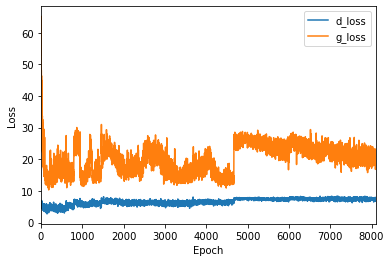

In [6]:
plt.plot(net.d_loss_list, label='d_loss')
plt.plot(net.g_loss_list, label='g_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim([0, len(net.g_loss_list)])
plt.legend(loc='upper right')

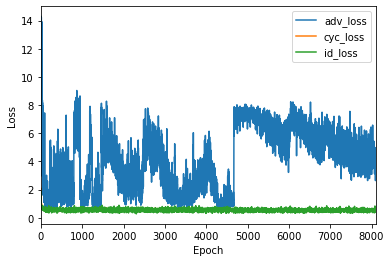

In [7]:
plt.plot(net.adv_loss_list, label='adv_loss')
plt.plot(net.cyc_loss_list, label='cyc_loss')
plt.plot(net.id_loss_list, label='id_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim([0, len(net.g_loss_list)])
plt.legend(loc='upper right')